## Descriptive statistics

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/Isha/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Read CSV files from data folder and store in dataframes
hackathons_webscraped = pd.read_csv('/Users/Isha/Desktop/TUe/Year 3/BEP/BEP_project/data/hackathons_webscraped_cleaned.csv')
hackathons = pd.read_csv('/Users/Isha/Desktop/TUe/Year 3/BEP/BEP_project/data/hackathons_modified.csv')
projects = pd.read_csv('/Users/Isha/Desktop/TUe/Year 3/BEP/BEP_project/data/projects_modified.csv')
participants_expanded = pd.read_csv('/Users/Isha/Desktop/TUe/Year 3/BEP/BEP_project/data/participants_expanded_gender.csv')

In [3]:
hackathons.columns
hackathons_webscraped.columns
del hackathons_webscraped['Unnamed: 0']
del hackathons['Unnamed: 0']
del participants_expanded['Unnamed: 0.1']
del participants_expanded['Unnamed: 0']

Thus, columns being transferred from webscraped to hackathons df are - 'Subtitles', 'Judging Criteria', 'Cleaned_Sponsors', 'Cleaned_Judges', 'Cleaned_Eligibility', 'Cleaned_Requirements'

In [4]:
# Thus, columns being transferred from hackathons_webscraped to hackathons are - 'Subtitles', 'Judging Criteria', 'Cleaned_Sponsors', 'Cleaned_Judges', 'Cleaned_Eligibility', 'Cleaned_Requirements'

hackathons['Subtitles'] = hackathons_webscraped['Subtitles']
hackathons['Sponsors'] = hackathons_webscraped['Cleaned_Sponsors']
hackathons['Judges'] = hackathons_webscraped['Cleaned_Judges']
hackathons['Eligibility'] = hackathons_webscraped['Cleaned_Eligibility']
hackathons['Requirements'] = hackathons_webscraped['Cleaned_Requirements']

# Rename column 'Criteria' to 'Judging Criteria'
hackathons = hackathons.rename(columns={'Criteria': 'Judging Criteria'})

In [6]:
#hackathons['combined_text'].sample(20)
hackathons.columns
#participants_expanded.columns

Index(['URL', 'Judging Criteria', 'schedule', 'hack_type', 'info',
       'start_date_format', 'end_date_format', 'Prizes', 'prize_money', 'Id',
       'Title', 'Location', 'start_date', 'end_date', 'year', 'themes',
       'prize', 'registered_N', 'featured', 'organization_name',
       'winners_announced', 'submission_gallery_url', 'start_a_submission_url',
       'Subtitles', 'Sponsors', 'Judges', 'Eligibility', 'Requirements'],
      dtype='object')

### Registered participants  described and visualised 

Descriptive Statistics for Number of Registered Participants:
count     7053.000000
mean       142.314193
std        432.513814
min          0.000000
25%         24.000000
50%         60.000000
75%        143.000000
max      18701.000000
Name: registered_N, dtype: float64


/Users/Isha/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


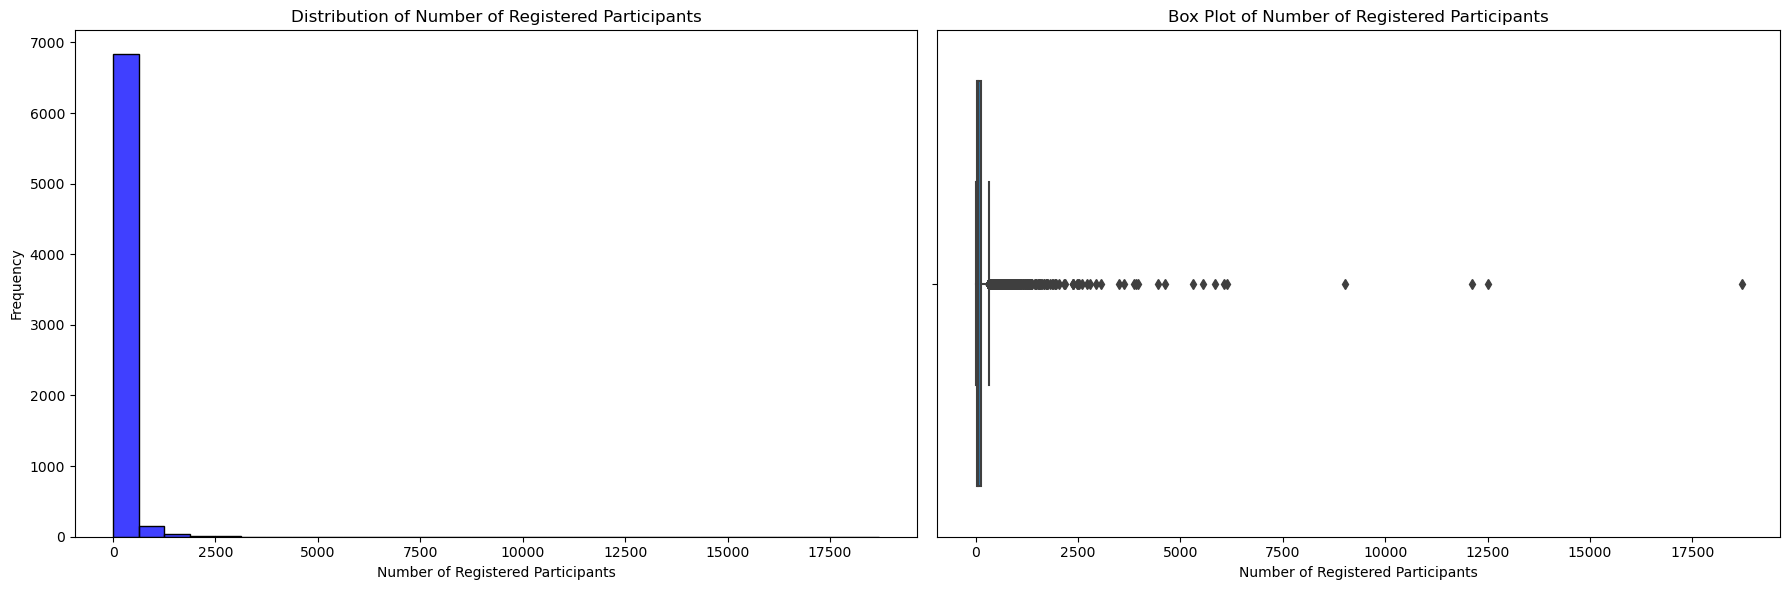

In [7]:
print("Descriptive Statistics for Number of Registered Participants:")
print(hackathons['registered_N'].describe())

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram
sns.histplot(hackathons['registered_N'], kde=False, bins=30, ax=axes[0], color='blue')
axes[0].set_title("Distribution of Number of Registered Participants")
axes[0].set_xlabel("Number of Registered Participants")
axes[0].set_ylabel("Frequency")

# Box Plot
sns.boxplot(x=hackathons['registered_N'], ax=axes[1])
axes[1].set_title("Box Plot of Number of Registered Participants")
axes[1].set_xlabel("Number of Registered Participants")

plt.tight_layout()
plt.show()


### Location distribution

In [ ]:
# Clean up the location by stripping white spaces and lowering the case
hackathons['normalized_location'] = hackathons['Location'].str.strip().str.lower()

# Correct common redundancies
# Example: Combining similar "new york" locations
hackathons['normalized_location'] = hackathons['normalized_location'].replace({
    "new york, ny, usa": "new york, ny, usa",
    "new york, new york, usa": "new york, ny, usa"
})

# Similarly, other similar location combinations can be handled
hackathons['normalized_location'].replace({
    "san francisco, ca, usa": "san francisco, ca, usa",
    "philadelphia, pa, usa": "philadelphia, pa, usa"
}, inplace=True)

# Count unique locations
unique_location_counts = hackathons['normalized_location'].value_counts()

unique_location_counts

In [ ]:
!pip install geopy
from geopy.geocoders import Nominatim
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Sample Data
unique_location_counts = unique_location_counts.reset_index()
unique_location_counts.columns = ['location', 'count']

# Geocoding function
geolocator = Nominatim(user_agent="hackathon_locator")

def get_coordinates(location):
    try:
        location_obj = geolocator.geocode(location, timeout=10)
        return (location_obj.latitude, location_obj.longitude)
    except:
        return (None, None)

# Add coordinates to the DataFrame
unique_location_counts['coordinates'] = unique_location_counts['location'].apply(get_coordinates)
unique_location_counts['latitude'] = unique_location_counts['coordinates'].apply(lambda x: x[0])
unique_location_counts['longitude'] = unique_location_counts['coordinates'].apply(lambda x: x[1])

# Drop rows with missing coordinates
unique_location_counts = unique_location_counts.dropna(subset=['latitude', 'longitude'])

# Display the DataFrame
unique_location_counts


In [ ]:
# Create a folium map
m = folium.Map(location=[20, 0], zoom_start=2)
marker_cluster = MarkerCluster().add_to(m)

# Add markers to the map
for _, row in unique_location_counts.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['location']}: {row['count']} hackathons",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Show map
m

### Online vs Offline participation allowed
create a new column called participation_type based on whether "online" is mentioned in the 'info' column.

In [8]:
# Step 1: Classify hackathons as online or offline
hackathons['participation_type'] = hackathons['info'].apply(
    lambda x: 'Online' if 'online' in x.lower() else 'Offline'
)

# Step 2: Count the number of hackathons for each type
participation_counts = hackathons['participation_type'].value_counts()
print(participation_counts)

participation_type
Offline    4546
Online     2507
Name: count, dtype: int64


In [9]:
# Assuming 'start_date_format' and 'end_date_format' are already in a suitable format (e.g., YYYY-MM-DD)
hackathons['start_date_format'] = pd.to_datetime(hackathons['start_date_format'])
hackathons['end_date_format'] = pd.to_datetime(hackathons['end_date_format'])

# Resample to monthly data, count number of hackathons starting each month
monthly_participation = hackathons.groupby('participation_type').resample('M', on='start_date_format').size().unstack(0, fill_value=0)

hackathons[['start_date_format','end_date_format']]
monthly_participation

/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_21685/1110240282.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_participation = hackathons.groupby('participation_type').resample('M', on='start_date_format').size().unstack(0, fill_value=0)


participation_type,Offline,Online
start_date_format,,
2009-10-31,0,1
2009-11-30,0,0
2009-12-31,0,0
2010-01-31,0,0
2010-02-28,0,0
...,...,...
2022-03-31,38,86
2022-04-30,70,82
2022-05-31,26,53


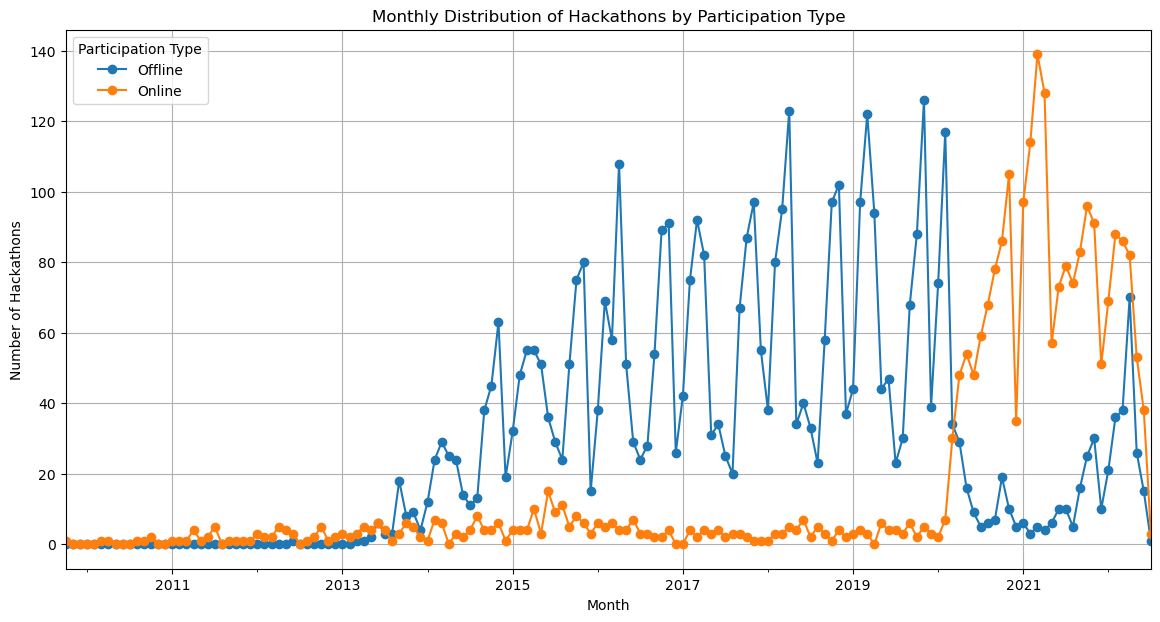

In [10]:
# Plotting
plt.figure(figsize=(14, 7))  # Set the figure size for better readability
monthly_participation.plot(kind='line', marker='o', ax=plt.gca())  # 'o' gives us points at each data point
plt.title('Monthly Distribution of Hackathons by Participation Type')
plt.xlabel('Month')
plt.ylabel('Number of Hackathons')
plt.grid(True)
plt.legend(title='Participation Type')
plt.show()

#### Graph Interpretation:
This graph represents the monthly distribution of hackathons categorized by participation type, specifically comparing 'Offline' and 'Online' formats over a timeline from 2011 to 2021. 
1. **Growth of Online Hackathons**: The frequency of online hackathons shows a visible increase over time, especially noticeable from around 2019 onwards. This could be attributed to several factors, such as technological advancements, the increasing accessibility of online platforms, or the global COVID-19 pandemic accelerating the shift towards virtual events.

2. **Volatility in Offline Hackathons**: Offline hackathons demonstrate significant fluctuations throughout the years. The peaks might represent popular annual or biannual hackathons, suggesting that certain months may consistently host more events due to strategic scheduling (e.g., avoiding holiday seasons, aligning with academic calendars).

3. **Consistent Low Activity in Early Years**: From 2011 to approximately mid-2013, both online and offline hackathons were relatively infrequent, which could indicate the nascent stage of hackathons becoming mainstream or the data collection starting to ramp up during this period.

4. **Major Shifts Post-2020**: Post-2020 shows a stark increase in online hackathons, possibly as a direct consequence of the COVID-19 pandemic restrictions, which forced many events to move online. This shift also corresponds with a decrease in offline events, highlighting how external factors like global crises can influence the format and frequency of such events.

5. **Seasonal and Annual Trends**: The graph might also hint at seasonal or annual trends in hackathon scheduling, with certain spikes suggesting preferred months for hosting hackathons. Further analysis could investigate whether these spikes correspond with specific seasons or parts of the academic year.

### Prize money vs No prize money 

In [11]:
# Step 1: Classify based on prize_money column
def classify_prize_money(value):
    value_str = str(value).lower()
    if 'no money prize' in value_str:
        return 'No Prize Money'
    else:
        return 'Has Prize Money'

hackathons['prize_money_status'] = hackathons['prize_money'].apply(classify_prize_money)

# Step 2: Count the number of hackathons for each category
prize_money_counts = hackathons['prize_money_status'].value_counts()
print(prize_money_counts)


prize_money_status
Has Prize Money    5276
No Prize Money     1777
Name: count, dtype: int64


### Duration of hackthons - for each, on average 1) for online vs offline 2) for prize money vs no prize money

In [12]:
# Convert dates to datetime format
hackathons['start_date_format'] = pd.to_datetime(hackathons['start_date_format'])
hackathons['end_date_format'] = pd.to_datetime(hackathons['end_date_format'])

# Calculate duration
hackathons['duration_days'] = (hackathons['end_date_format'] - hackathons['start_date_format']).dt.days

In [13]:
hackathons['duration_days'].describe()

count    7053.000000
mean        8.386786
std        22.412953
min        -2.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       403.000000
Name: duration_days, dtype: float64

In [14]:
# Calculate average duration for Online vs Offline
average_duration_online_offline = hackathons.groupby('participation_type')['duration_days'].mean()
print("Average Duration (Online vs Offline):")
print(average_duration_online_offline)

# Calculate average duration for Prize Money vs No Prize Money
average_duration_prize_money = hackathons.groupby('prize_money_status')['duration_days'].mean()
print("\nAverage Duration (Prize Money vs No Prize Money):")
print(average_duration_prize_money)

Average Duration (Online vs Offline):
participation_type
Offline     2.751870
Online     18.604707
Name: duration_days, dtype: float64

Average Duration (Prize Money vs No Prize Money):
prize_money_status
Has Prize Money    9.257392
No Prize Money     5.801913
Name: duration_days, dtype: float64


In [15]:
# Calculate average duration for each combination
average_duration_combination = hackathons.groupby(['participation_type', 'prize_money_status'])['duration_days'].mean()

# Display the results
print("Average Duration (Online/Offline + Prize Money/No Prize Money):")
print(average_duration_combination)

Average Duration (Online/Offline + Prize Money/No Prize Money):
participation_type  prize_money_status
Offline             Has Prize Money        2.448826
                    No Prize Money         3.574346
Online              Has Prize Money       20.832651
                    No Prize Money        10.732369
Name: duration_days, dtype: float64


### Public Vs Private (Invite only) hackathons

In [16]:
hack_type_counts = hackathons['hack_type'].value_counts()
print(hack_type_counts)

hack_type
Public         6692
Invite only     361
Name: count, dtype: int64


In [17]:
# Calculate average duration for each combination
average_hack_duration_combination = hackathons.groupby(['hack_type', 'prize_money_status'])['duration_days'].mean()
print(average_hack_duration_combination)

hack_type    prize_money_status
Invite only  Has Prize Money        4.022727
             No Prize Money        10.391753
Public       Has Prize Money        9.533121
             No Prize Money         5.536905
Name: duration_days, dtype: float64


### Themes
Given the structure of the themes column in the hackathons DataFrame, where themes are nested in double brackets, we first extract the inner list to have a list of themes for each hackathon. Then we can count the unique themes across all hackathons.

In [ ]:
from collections import Counter

# Ensure the column is treated as string and split on ', ' to get lists of themes
hackathons['themes'] = hackathons['themes'].astype(str).apply(lambda x: x.split(', '))

# Verify the operation worked as expected by inspecting the first few entries
# print(hackathons['themes'].head())

# Flatten the list of lists into a single list
all_themes = [theme for sublist in hackathons['themes'].dropna() for theme in sublist]

# Count the frequency of each theme
theme_counts = Counter(all_themes)

theme_counts

#### Themes Synonymous with "Learning":
Machine Learning/AI,
Beginner Friendly,
Education,
DevOps,
Low/No Code,
Quantum

#### Themes Synonymous with "Networking"
Social Good,
AR/VR,
Blockchain,
Communication,
Web

#### Themes Synonymous with "Experience"
Open Ended,
Voice skills,
Productivity,
Gaming,
Music/Art,
IoT,
Design,
Fintech,
Health,
Enterprise,
E-commerce/Retail,

In [ ]:
# Display the most common themes
print("Most common themes and their counts:")
for theme, count in theme_counts.most_common():
    print(f"{theme}: {count}")

hackathons['themes']

Categorising the themes into a theme_focus_domain among: Learning, Experience, Networking, and Development

In [ ]:
# Define the keywords
learning_themes = {"Beginner Friendly", "Education", "DevOps", "Low/No Code"}
networking_themes = {"Social Good", "Communication", "COVID-19"}
experience_themes = {"Open Ended", "Voice skills", "Productivity", "Lifehacks"}
development_themes = {"Machine Learning/AI", "Quantum", "AR/VR", "Blockchain", "Web", "Gaming", "Music/Art", "IoT", "Design", "Fintech", "Health", "Enterprise", "E-commerce/Retail", "Mobile"}
not_specified_theme = {"Not Specified"}

def classify_theme(themes):
    focus = set()
    
    for theme in themes:
        if theme in learning_themes:
            focus.add("Learning")
        if theme in networking_themes:
            focus.add("Networking")
        if theme in experience_themes:
            focus.add("Experience")
        if theme in development_themes:
            focus.add("Development")
        if theme in not_specified_theme:
            focus.add("Not Specified")
    
    return ', '.join(sorted(focus))

# Assuming 'hackathons' is your DataFrame and 'themes' is the column with the list of themes
hackathons['theme_domain_focus'] = hackathons['themes'].apply(classify_theme)

# Display the resulting DataFrame
hackathons[['themes','prize_money','prize_money_status','theme_domain_focus']]

### Feedback: just use tags and classify after analysis

## Classifying hackathons as women-targeted, women-encouraged, no explicit initiative

In [48]:
#creating column combined_text using columns
# Assuming hackathons is your DataFrame
hackathons['combined_text'] = hackathons[['Subtitles', 'Judging Criteria', 'Sponsors', 'Eligibility']].fillna('').agg(' '.join, axis=1)
hackathons['combined_text']

0       Wie können wir als Gesellschaft die Herausford...
1       Fighting a Global Crisis - 3 billion people in...
2       Internet Computer Web3 Hackathon X Factor and ...
3       #Hajj_Hackathon                               ...
4       Build the next generation of Web3 apps with $5...
                              ...                        
7048                                              biden  
7049                   Criteria 1, Criteria 1, criteria  
7050                                                TBA  
7051                                              biden  
7052                                     Firts criteria  
Name: combined_text, Length: 7053, dtype: object

### method 1:

In [55]:
# Expanded keyword sets
keywords_women_targeted = {
    'woman','women', 'all-women', 'female-focused', 'ladies', 'woman-owned', 'women in tech', 'women developers', 'girls in tech', 'tech girl', 'hack gurl'
    'female engineers', 'women entrepreneurs', 'female mentors', 'women-led', 'female panelists', 'women in stem','girl', 'girls',
    'female coders', 'women in engineering', 'support for women', 'promoting women in tech', 'female participation',
    'women techmakers', 'women in leadership', 'women’s networking', 'female startup founders', 'women in digital',
    'female innovators', 'supporting women in tech', "women's empowerment in technology", 'women tech entrepreneurs',
    'tech women', 'women achievers in tech', 'women’s tech hub', 'female tech community', 'encouraging women in tech',
    'female mentorship programs', 'women in cybersecurity', 'advocacy for women in tech','women-only', 'female-only event', 'exclusively for women'
}

keywords_women_encouraged = {
    'female', 'gender inclusive', 'diversity', 'girl', 'girls', 'gender equity', 'she/her', 
    'gender balance', 'equity', 'inclusive', 'underrepresented genders', 'gender diversity', 
    'gender parity', 'empower women', 'female empowerment', 'gender-neutral', 'non-binary', 
    'inclusivity', 'minority women', 'female leadership', 'diverse teams', 'gender-sensitive', 
    'affirmative action', 'equal opportunity', 'gender-responsive', 'gender-inclusive language', 
    'empowering underrepresented groups', 'gender equality in tech', 'feminism in tech', 
    'safe space for women', 'pro-women policies', 'promoting gender diversity', 'equitable representation', 
    'gender-smart solutions', 'tech gender gap', 'encourages women', 'female participants welcome', 
    'promoting gender diversity'
}


In [56]:
import re
# Convert 'Eligibility' to string and replace NaNs with an empty string
hackathons['Eligibility'] = hackathons['Eligibility'].fillna('').astype(str)

def classify_hackathon(text):
    # Ensure text is in lowercase
    text = text.lower()  # This should now work without errors
    
    # Count the occurrences of each set of keywords
    targeted_count = sum(1 for keyword in keywords_women_targeted if re.search(r'\b' + re.escape(keyword) + r'\b', text))
    encouraged_count = sum(1 for keyword in keywords_women_encouraged if re.search(r'\b' + re.escape(keyword) + r'\b', text))
    
    # Classify based on the counts
    if targeted_count > 0:
        return 'Women-targeted'
    elif encouraged_count > 0:
        return 'Women-encouraged'
    else:
        return 'No explicit gender diversity initiative'

# Apply the classification function
hackathons['classification'] = hackathons['Eligibility'].apply(classify_hackathon)

A function classify_hackathon takes a text (from the 'Eligibility' field), converts it to lowercase to standardize the data, and then checks for the presence of any keywords from both keyword sets using regular expressions.
The use of \b (word boundary) in regex ensures that keywords are matched as whole words, preventing partial matches (like "he" in "the").
It counts occurrences of keywords related to both targeted and encouraged categories. If any targeted keywords are found, it classifies the hackathon as 'Women-targeted'. If none are found but encouraged keywords are present, it classifies as 'Women-encouraged'. If neither are found, it defaults to 'No explicit gender diversity initiative'.

classification
No explicit gender diversity initiative    6846
Women-encouraged                            118
Women-targeted                               89
Name: count, dtype: int64


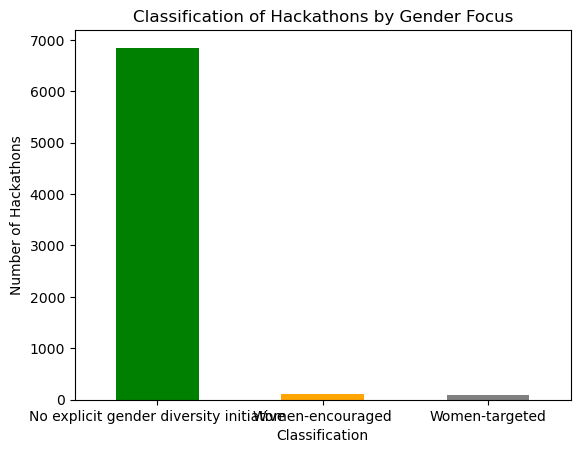

In [57]:
# Analyze classification counts
classification_counts = hackathons['classification'].value_counts()
print(classification_counts)

# Visualization
classification_counts.plot(kind='bar', color=['green', 'orange', 'grey'])
plt.title('Classification of Hackathons by Gender Focus')
plt.xlabel('Classification')
plt.ylabel('Number of Hackathons')
plt.xticks(rotation=0)
plt.show()


In [54]:
# Sample review
hackathons[['URL', 'Eligibility', 'classification']].sample(10)

,URL,Eligibility,classification
5771,https://versusvirus-croatia.devpost.com/,Eligibility This hackathon page is aimed at th...,No explicit gender diversity initiative
949,https://copernicus.devpost.com/,Eligibility Participants are individuals that ...,No explicit gender diversity initiative
4731,https://csirosolarhackathon.devpost.com/,Eligibility Team Size: Minimum of 3 - Maximum ...,No explicit gender diversity initiative
1886,https://harvard-hacking-autism.devpost.com/,Eligibility information not provided,No explicit gender diversity initiative
1270,https://diversityhack.devpost.com/,Eligibility Мы принимаем заявки от всех желающ...,No explicit gender diversity initiative
1361,https://acalltoall.devpost.com/,Eligibility -Everyone is welcome to attend -Ha...,No explicit gender diversity initiative
1864,https://orb-a-palooza-boston.devpost.com/,Eligibility All participants must: Register fo...,No explicit gender diversity initiative
712,https://hackdc2015.devpost.com/,Eligibility Over 18 years of age. Undergraduat...,No explicit gender diversity initiative
209,https://pearlhacks.devpost.com/,Eligibility ChallengePost submissions are open...,Women-targeted
6231,https://bqgirlhacks.devpost.com/,Eligibility Be a high school girl interested i...,Women-encouraged


### method 2:

In [58]:
import pandas as pd

# Define a function to categorize each hackathon
def classify_hackathon(row):
    # Women-targeted keywords
    women_targeted_keywords = [
    'women only', 'all-women', 'female-focused', 'woman-owned', 'women in tech', 
    'women developers', 'female engineers', 'women entrepreneurs', 'female mentors', 'women-led', 'girl', 'girls',
    'female panelists', 'women in stem', 'female coders', 'women in engineering', 'support for women', 
    'promoting women in tech', 'female participation', 'women techmakers', 'women in leadership', 
    'women’s networking', 'female startup founders', 'women in digital', 'female innovators', 
    'supporting women in tech', "women's empowerment in technology", 'women tech entrepreneurs', 
    'tech women', 'women achievers in tech', 'women’s tech hub', 'female tech community', 
    'encouraging women in tech', 'female mentorship programs', 'women in cybersecurity', 
    'advocacy for women in tech', 'women-only', 'female-only event', 'exclusively for women', 'TechTogether']

    # Women-encouraged keywords
    women_encouraged_keywords = [
    'female', 'gender inclusive', 'diversity', 'girl', 'girls', 'gender equity', 'she/her', 
    'gender balance', 'equity', 'inclusive', 'underrepresented genders', 'gender diversity', 
    'gender parity', 'empower women', 'female empowerment', 'gender-neutral', 'non-binary', 
    'inclusivity', 'minority women', 'female leadership', 'diverse teams', 'gender-sensitive', 
    'affirmative action', 'equal opportunity', 'gender-responsive', 'gender-inclusive language', 
    'empowering underrepresented groups', 'gender equality in tech', 'feminism in tech', 
    'safe space for women', 'pro-women policies', 'promoting gender diversity', 'equitable representation', 
    'gender-smart solutions', 'tech gender gap', 'encourages women', 'female participants welcome', 
    'promoting gender diversity']
    
   
    # Convert to lower case to ensure case insensitivity
    text = row['combined_text'].lower() if pd.notna(row['combined_text']) else ""
    
    # Check for women-targeted keywords
    if any(keyword in text for keyword in women_targeted_keywords):
        return 'Women-targeted'
    # Check for women-encouraged keywords
    elif any(keyword in text for keyword in women_encouraged_keywords):
        return 'Women-encouraged'
    # Default category
    return 'No explicit gender diversity initiative'

# Apply the classifier to each row in the DataFrame
hackathons['category'] = hackathons.apply(classify_hackathon, axis=1)


In [ ]:
# Sample review
hackathons[['URL', 'Eligibility', 'category']].sample(30)

category
No explicit gender diversity initiative    6642
Women-encouraged                            272
Women-targeted                              139
Name: count, dtype: int64


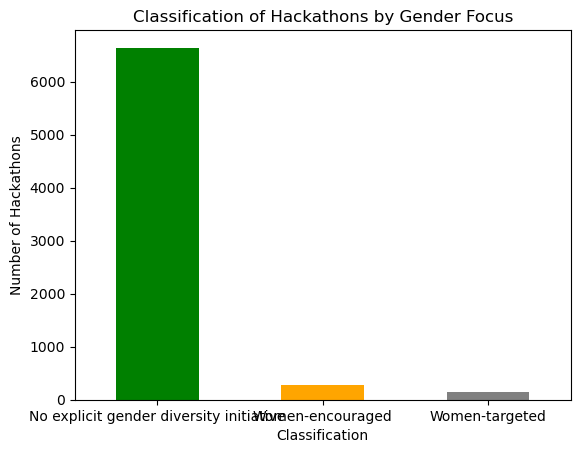

In [59]:
# Analyze classification counts
classification_counts = hackathons['category'].value_counts()
print(classification_counts)

# Visualization
classification_counts.plot(kind='bar', color=['green', 'orange', 'grey'])
plt.title('Classification of Hackathons by Gender Focus')
plt.xlabel('Classification')
plt.ylabel('Number of Hackathons')
plt.xticks(rotation=0)
plt.show()


### method 3:

In [60]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.9 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [61]:
import spacy
from spacy.tokens import Token

# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# Custom extension to store a simple sentiment score
Token.set_extension('is_positive', default=False, force=True)

def analyze_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    
    # Example sentiment analysis (naive implementation)
    positive_words = ['support', 'empower', 'encourage', 'inclusive', 'welcome']
    for token in doc:
        # Simple check for positive words
        if token.lemma_ in positive_words:
            token._.is_positive = True
    
    # Dependency parsing to find subjects related to women
    for token in doc:
        if token.text.lower() in ['women', 'female', 'girl', 'ladies']:
            # Check for adjectives linked to these subjects
            for child in token.children:
                if child.dep_ in ['amod', 'acl:relcl'] and child._.is_positive:
                    print(f"Positive sentiment about women found: {child.text} {token.text}")
    
    return doc

# Example usage
text = "We welcome female engineers to our conference designed to support women in tech."
analyzed_doc = analyze_text(text)

analyzed_doc


/Users/Isha/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We welcome female engineers to our conference designed to support women in tech.

In [62]:
def classify_hackathon(row):
    text = row['combined_text'].lower() if pd.notna(row['combined_text']) else ""
    
    # Process text with spaCy
    doc = analyze_text(text)
    
    # Use previously defined keyword lists and enhanced analysis
    # (Implement similar checks as shown above using refined criteria and output from analyze_text)
    # Women-targeted keywords
    women_targeted_keywords = [
    'women only', 'all-women', 'female-focused', 'woman-owned', 'women in tech', 
    'women developers', 'female engineers', 'women entrepreneurs', 'female mentors', 'women-led', 'girl', 'girls',
    'female panelists', 'women in stem', 'female coders', 'women in engineering', 'support for women', 
    'promoting women in tech', 'female participation', 'women techmakers', 'women in leadership', 
    'women’s networking', 'female startup founders', 'women in digital', 'female innovators', 
    'supporting women in tech', "women's empowerment in technology", 'women tech entrepreneurs', 
    'tech women', 'women achievers in tech', 'women’s tech hub', 'female tech community', 
    'encouraging women in tech', 'female mentorship programs', 'women in cybersecurity', 
    'advocacy for women in tech', 'women-only', 'female-only event', 'exclusively for women', 'TechTogether']

    # Women-encouraged keywords
    women_encouraged_keywords = [
    'female', 'gender inclusive', 'diversity', 'girl', 'girls', 'gender equity', 'she/her', 
    'gender balance', 'equity', 'inclusive', 'underrepresented genders', 'gender diversity', 
    'gender parity', 'empower women', 'female empowerment', 'gender-neutral', 'non-binary', 
    'inclusivity', 'minority women', 'female leadership', 'diverse teams', 'gender-sensitive', 
    'affirmative action', 'equal opportunity', 'gender-responsive', 'gender-inclusive language', 
    'empowering underrepresented groups', 'gender equality in tech', 'feminism in tech', 
    'safe space for women', 'pro-women policies', 'promoting gender diversity', 'equitable representation', 
    'gender-smart solutions', 'tech gender gap', 'encourages women', 'female participants welcome', 
    'promoting gender diversity']

    
    # Check for women-targeted keywords
    if any(keyword in text for keyword in women_targeted_keywords):
        return 'Women-targeted'
    # Check for women-encouraged keywords
    elif any(keyword in text for keyword in women_encouraged_keywords):
        return 'Women-encouraged'
    # Default category
    return 'No explicit gender diversity initiative'


# Apply the classifier to each row in the DataFrame
hackathons['category'] = hackathons.apply(classify_hackathon, axis=1)


category
No explicit gender diversity initiative    6642
Women-encouraged                            272
Women-targeted                              139
Name: count, dtype: int64


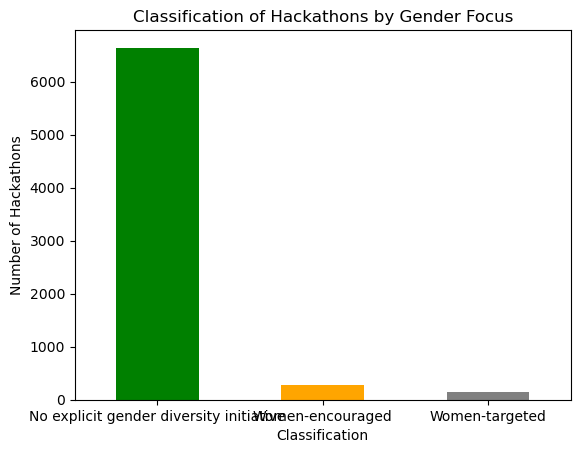

In [63]:
# Analyze classification counts
classification_counts = hackathons['category'].value_counts()
print(classification_counts)

# Visualization
classification_counts.plot(kind='bar', color=['green', 'orange', 'grey'])
plt.title('Classification of Hackathons by Gender Focus')
plt.xlabel('Classification')
plt.ylabel('Number of Hackathons')
plt.xticks(rotation=0)
plt.show()


### gave the same result as above - why
If the outputs from methods 2 and 3 are identical, it likely indicates that the additional complexity introduced in method 3 (using spaCy for sentiment and dependency analysis) isn't actually affecting the final classification decision

### method 4:

In [67]:
#!pip install spacy nltk pandas matplotlib
#!python -m spacy download en_core_web_sm

#install VADER and other modules
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import spacy
from matplotlib import pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from spacy.tokens import Span

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Isha/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [69]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def analyze_text(text):
    doc = nlp(text)
    sentiment_score = 0  # Default sentiment score
    # Aggregate sentiment score using VADER
    for sent in doc.sents:
        sentiment_score += sia.polarity_scores(sent.text)['compound']
    return sentiment_score, doc

In [70]:
# Women-targeted keywords
women_targeted_keywords = [
    'women only', 'all-women', 'female-focused', 'ladies', 'woman-owned', 'women in tech', 
    'women developers', 'female engineers', 'women entrepreneurs', 'female mentors', 'women-led', 
    'female panelists', 'women in stem', 'female coders', 'women in engineering', 'support for women', 
    'promoting women in tech', 'female participation', 'women techmakers', 'women in leadership', 
    'women’s networking', 'female startup founders', 'women in digital', 'female innovators', 
    'supporting women in tech', "women's empowerment in technology", 'women tech entrepreneurs', 
    'tech women', 'women achievers in tech', 'women’s tech hub', 'female tech community', 
    'encouraging women in tech', 'female mentorship programs', 'women in cybersecurity', 
    'advocacy for women in tech', 'women-only', 'female-only event', 'exclusively for women'
]

# Women-encouraged keywords
women_encouraged_keywords = [
    'female', 'gender inclusive', 'diversity', 'girl', 'girls', 'gender equity', 'she/her', 
    'gender balance', 'equity', 'inclusive', 'underrepresented genders', 'gender diversity', 
    'gender parity', 'empower women', 'female empowerment', 'gender-neutral', 'non-binary', 
    'inclusivity', 'minority women', 'female leadership', 'diverse teams', 'gender-sensitive', 
    'affirmative action', 'equal opportunity', 'gender-responsive', 'gender-inclusive language', 
    'empowering underrepresented groups', 'gender equality in tech', 'feminism in tech', 
    'safe space for women', 'pro-women policies', 'promoting gender diversity', 'equitable representation', 
    'gender-smart solutions', 'tech gender gap', 'encourages women', 'female participants welcome', 
    'promoting gender diversity'
]

def classify_hackathon(row):
    text = row['combined_text'].lower() if pd.notna(row['combined_text']) else ""
    
    # Check for women-targeted keywords
    if any(keyword in text for keyword in women_targeted_keywords):
        return 'Women-targeted'
    # Check for women-encouraged keywords
    elif any(keyword in text for keyword in women_encouraged_keywords):
        return 'Women-encouraged'
    # Default category
    return 'No explicit gender diversity initiative'

# Apply the classifier to each row in the DataFrame
hackathons['category'] = hackathons.apply(classify_hackathon, axis=1)


category
No explicit gender diversity initiative    6637
Women-encouraged                            347
Women-targeted                               69
Name: count, dtype: int64


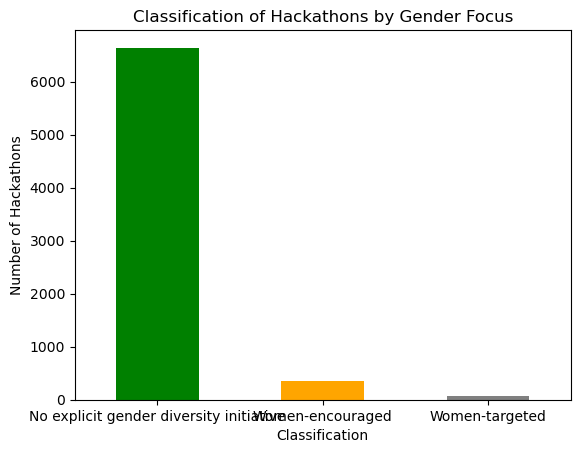

In [71]:
# Analyze classification counts
classification_counts = hackathons['category'].value_counts()
print(classification_counts)

# Visualization
classification_counts.plot(kind='bar', color=['green', 'orange', 'grey'])
plt.title('Classification of Hackathons by Gender Focus')
plt.xlabel('Classification')
plt.ylabel('Number of Hackathons')
plt.xticks(rotation=0)
plt.show()

### trying to solve an issue in classification such that it actually uses VADER's sentiment scores 

In [72]:
def classify_hackathon(row):
    text = row['combined_text'].lower() if pd.notna(row['combined_text']) else ""
    
    # Analyze sentiment
    sentiment_score, doc = analyze_text(text)

    # Adjust classification criteria based on sentiment
    if any(keyword in text for keyword in women_targeted_keywords):
        # Enhance targeting if the sentiment is positive
        if sentiment_score > 0:
            return 'Women-targeted'
        else:
            return 'Women-targeted (neutral sentiment)'
    elif any(keyword in text for keyword in women_encouraged_keywords):
        # Encouragement classification can consider sentiment to differentiate enthusiasm levels
        if sentiment_score > 0:
            return 'Women-encouraged (positive sentiment)'
        elif sentiment_score < 0:
            return 'Women-encouraged (negative sentiment)'
        else:
            return 'Women-encouraged (neutral sentiment)'
    # Default category
    return 'No explicit gender diversity initiative'

# Apply the classifier to each row in the DataFrame
hackathons['category'] = hackathons.apply(classify_hackathon, axis=1)

# Analyze classification counts
classification_counts = hackathons['category'].value_counts()
print(classification_counts)

category
No explicit gender diversity initiative    6637
Women-encouraged (positive sentiment)       304
Women-targeted                               58
Women-encouraged (neutral sentiment)         22
Women-encouraged (negative sentiment)        21
Women-targeted (neutral sentiment)           11
Name: count, dtype: int64


### Result interpretation:
**No explicit gender diversity initiative (6637):**
This is the largest category. It includes hackathons that do not use any of the keywords associated with targeting or encouraging women, nor show any sentiment that could imply an indirect encouragement. These events likely do not specifically focus on gender diversity based on the textual data analyzed.

**Women-encouraged (positive sentiment) (304):**
These hackathons contain keywords that suggest an encouragement of women's participation and are associated with positive sentiment. This implies not only a mention of gender inclusivity but also a positive promotion or support of women in the context of the event.

**Women-targeted (58):**
This category consists of hackathons explicitly aimed at women, likely including terms like "women-only" or "female-only event". However, these classifications do not take sentiment into account, suggesting the presence of keywords was sufficient to classify them as targeted, regardless of sentiment.

**Women-encouraged (neutral sentiment) (22):**
Hackathons in this category include encouraging keywords but the overall sentiment expressed in the related texts is neutral, suggesting neither explicit support nor opposition to gender diversity themes.

**Women-encouraged (negative sentiment) (21):**
Similar to the above but with a negative sentiment. This is particularly interesting as it suggests that while the event might encourage female participation, the context or tone in which it is mentioned could be discouraging or critical.

**Women-targeted (neutral sentiment) (11):**
This includes hackathons specifically targeting women but without any positive or negative sentiment attached to the mentions. The neutrality might suggest a factual or unenthusiastic mention of targeting.

In [77]:
# Assuming 'hackathons' is your DataFrame and 'category' is the column with the classification results
negative_sentiment_hackathons = hackathons[hackathons['category'] == 'Women-encouraged (negative sentiment)']

# Check if there are any entries in this filtered DataFrame
if not negative_sentiment_hackathons.empty:
    example_hackathon = negative_sentiment_hackathons.iloc[0]  # Get the first row as an example
    print("Example of a hackathon classified as Women-encouraged (negative sentiment):")
    print("Description or Text: ", example_hackathon['combined_text'], example_hackathon['URL'])
else:
    print("No hackathons found in the 'Women-encouraged (negative sentiment)' category.")


Example of a hackathon classified as Women-encouraged (negative sentiment):
Description or Text:  Inclusive all-female hackathon to solve real-time problems. Originality, Usefulness, Functionality, Difficulty, Presentation [] Eligibility information not provided https://hack-wizard.devpost.com/


If a hackathon classified as "Women-encouraged (negative sentiment)" contains seemingly positive words like "welcoming" and "supportive," it may happen because of Contrastive Usage: Words like "welcoming" and "supportive" might appear in a context that contrasts them with negative statements, such as "claimed to be welcoming but felt exclusive" or "supposedly supportive but actually discouraging."/ VADER's Sensitivity: VADER (the sentiment analysis tool used) is tuned for social media text and might not always accurately capture the sentiment of more complex or subtly nuanced text, like formal event descriptions or hackathon announcements.

### method 5: 
looked at the combined_text column but I would also like to go through some other columns since those might help increase the accuracy of classification - 'Subtitles', 'Judging Criteria' , ‘Sponsors’. 

Then perhaps implementing a Frequency Count: Measure how many times each keyword appears in the text. 
And then Determine a benchmark to classify an event as women-targeted or women-encouraged: Fixed Count: E.g., if "women" or similar keywords appear three or more times in different contexts. or could try Percentage of Text: E.g., if keywords related to women make up a certain percentage of the total text. or even Keyword Combination: E.g., if multiple different keywords appear in the same description, suggesting a deliberate focus.
and then Classify hackathons based on these

In [ ]:
# Combine Relevant Text Columns
#hackathons['all_text'] = hackathons[['Subtitles', 'Judging Criteria', 'Sponsors', 'combined_text']].fillna('').agg(' '.join, axis=1)

In [78]:
# Implement Frequency Count
from collections import Counter
import re

def keyword_frequency(text, keywords):
    words = re.findall(r'\b\w+\b', text.lower())
    counter = Counter(words)
    keyword_count = sum(counter[keyword] for keyword in keywords if keyword in counter)
    total_words = sum(counter.values())
    return keyword_count, total_words


In [79]:
# Classification Based on Frequency
def classify_hackathon(row):
    text = row['combined_text'].lower()
    keyword_count, total_words = keyword_frequency(text, women_targeted_keywords)
    
    # Example thresholds
    fixed_threshold = 3  # Fixed count threshold
    percentage_threshold = 0.005  # Percentage of total words
    
    # Women-targeted: Fixed count or percentage of text
    if keyword_count >= fixed_threshold or (keyword_count / total_words) >= percentage_threshold:
        return 'Women-targeted'
    
    # Check for women-encouraged
    keyword_count, total_words = keyword_frequency(text, women_encouraged_keywords)
    if keyword_count >= fixed_threshold or (keyword_count / total_words) >= percentage_threshold:
        return 'Women-encouraged'
    
    return 'No explicit gender diversity initiative'


hackathons['category'] = hackathons.apply(classify_hackathon, axis=1)

category
No explicit gender diversity initiative    6749
Women-encouraged                            298
Women-targeted                                6
Name: count, dtype: int64


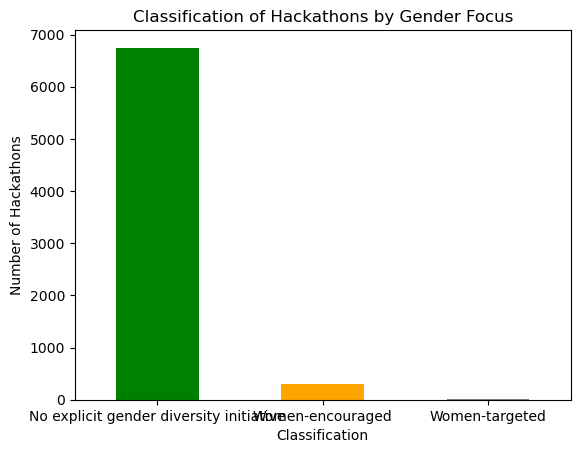

In [80]:
classification_counts = hackathons['category'].value_counts()
print(classification_counts)

# Visualization
classification_counts.plot(kind='bar', color=['green', 'orange', 'grey'])
plt.title('Classification of Hackathons by Gender Focus')
plt.xlabel('Classification')
plt.ylabel('Number of Hackathons')
plt.xticks(rotation=0)
plt.show()

Since this is a very quantitative approach, it can be improved by incorporating some NLP techniques that account for the context in which keywords

In [82]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from collections import Counter
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [84]:
def tfidf_keywords(texts, keywords):
    # Filter only sentences containing keywords
    filtered_texts = []
    for doc in nlp.pipe(texts):
        sents = [sent.text for sent in doc.sents if any(token.lower_ in keywords for token in sent)]
        filtered_texts.append(" ".join(sents))
    
    # Calculate TF-IDF scores
    vectorizer = TfidfVectorizer(vocabulary=keywords, lowercase=True)
    X = vectorizer.fit_transform(filtered_texts)
    feature_names = vectorizer.get_feature_names_out()
    scores = []
    for row in X.toarray():
        scores.append(dict(zip(feature_names, row)))
    return scores

# Keywords defined as previously
women_targeted_keywords = [
    'women only', 'all-women', 'female-focused', 'ladies', 'woman-owned', 'women in tech', 
    'women developers', 'female engineers', 'women entrepreneurs', 'female mentors', 'women-led', 
    'female panelists', 'women in stem', 'female coders', 'women in engineering', 'support for women', 
    'promoting women in tech', 'female participation', 'women techmakers', 'women in leadership', 
    'women’s networking', 'female startup founders', 'women in digital', 'female innovators', 
    'supporting women in tech', "women's empowerment in technology", 'women tech entrepreneurs', 
    'tech women', 'women achievers in tech', 'women’s tech hub', 'female tech community', 
    'encouraging women in tech', 'female mentorship programs', 'women in cybersecurity', 
    'advocacy for women in tech', 'women-only', 'female-only event', 'exclusively for women'
]

# Women-encouraged keywords
women_encouraged_keywords = [
    'female', 'gender inclusive', 'diversity', 'girl', 'girls', 'gender equity', 'she/her', 
    'gender balance', 'equity', 'inclusive', 'underrepresented genders', 'gender diversity', 
    'gender parity', 'empower women', 'female empowerment', 'gender-neutral', 'non-binary', 
    'inclusivity', 'minority women', 'female leadership', 'diverse teams', 'gender-sensitive', 
    'affirmative action', 'equal opportunity', 'gender-responsive', 'gender-inclusive language', 
    'empowering underrepresented groups', 'gender equality in tech', 'feminism in tech', 
    'safe space for women', 'pro-women policies', 'equitable representation', 
    'gender-smart solutions', 'tech gender gap', 'encourages women', 'female participants welcome', 
    'promoting gender diversity'
]

# Example: Calculate TF-IDF scores
tfidf_scores = tfidf_keywords(hackathons['combined_text'], women_targeted_keywords + women_encouraged_keywords)


In [85]:
def classify_based_on_tfidf(row, tfidf_scores):
    scores = tfidf_scores[row.name]
    # Set your thresholds based on experimentation and observation
    targeted_threshold = 0.1
    encouraged_threshold = 0.05
    
    # Classification logic
    if any(scores[keyword] >= targeted_threshold for keyword in women_targeted_keywords):
        return 'Women-targeted'
    elif any(scores[keyword] >= encouraged_threshold for keyword in women_encouraged_keywords):
        return 'Women-encouraged'
    return 'No explicit gender diversity initiative'

# Apply classification
df['classification'] = df.apply(classify_based_on_tfidf, args=(tfidf_scores,), axis=1)
print(df[['combined_text', 'classification']])


                                       combined_text  \
0        We welcome all women to the tech conference   
1  This conference is for everyone, promoting gen...   

                            classification  
0  No explicit gender diversity initiative  
1  No explicit gender diversity initiative  


In [86]:
classification_counts = hackathons['classification'].value_counts()
print(classification_counts)

classification
No explicit gender diversity initiative    6846
Women-encouraged                            118
Women-targeted                               89
Name: count, dtype: int64


## Method 6: Hybrid Approach of 4 and 5

In [91]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download necessary resources
nltk.download('vader_lexicon')

# Load NLP models
nlp = spacy.load('en_core_web_sm')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Isha/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [96]:
## Define Helper Functions
# Function to analyze sentiment
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Function to preprocess text and calculate TF-IDF for keywords
def tfidf_preprocess(texts, keywords):
    vectorizer = TfidfVectorizer(vocabulary=keywords, lowercase=True)
    tfidf_scores = vectorizer.fit_transform(texts)
    return tfidf_scores, vectorizer.get_feature_names_out()

# Define keywords
keywords = {
    'women_targeted': ['women only', 'all-women', 'female-focused', 'ladies', 'woman-owned', 'women in tech', 
    'women developers', 'female engineers', 'women entrepreneurs', 'female mentors', 'women-led', 
    'female panelists', 'women in stem', 'female coders', 'women in engineering', 'support for women', 
    'promoting women in tech', 'female participation', 'women techmakers', 'women in leadership', 
    'women’s networking', 'female startup founders', 'women in digital', 'female innovators', 
    'supporting women in tech', "women's empowerment in technology", 'women tech entrepreneurs', 
    'tech women', 'women achievers in tech', 'women’s tech hub', 'female tech community', 
    'encouraging women in tech', 'female mentorship programs', 'women in cybersecurity', 
    'advocacy for women in tech', 'women-only', 'female-only event', 'exclusively for women'],
    
    'women_encouraged': ['female', 'gender inclusive', 'diversity', 'girl', 'girls', 'gender equity', 'she/her', 
    'gender balance', 'equity', 'inclusive', 'underrepresented genders', 'gender diversity', 
    'gender parity', 'empower women', 'female empowerment', 'gender-neutral', 'non-binary', 
    'inclusivity', 'minority women', 'female leadership', 'diverse teams', 'gender-sensitive', 
    'affirmative action', 'equal opportunity', 'gender-responsive', 'gender-inclusive language', 
    'empowering underrepresented groups', 'gender equality in tech', 'feminism in tech', 
    'safe space for women', 'pro-women policies', 'equitable representation', 
    'gender-smart solutions', 'tech gender gap', 'encourages women', 'female participants welcome', 
    'promoting gender diversity']
}
all_keywords = [kw for sublist in keywords.values() for kw in sublist]

# Function to classify based on sentiment and keyword TF-IDF
def classify_hackathons(row, tfidf_scores, feature_names):
    idx = row.name
    targeted_score = sum(tfidf_scores[idx, i] for i, word in enumerate(feature_names) if word in keywords['women_targeted'])
    encouraged_score = sum(tfidf_scores[idx, i] for i, word in enumerate(feature_names) if word in keywords['women_encouraged'])

    if row['sentiment'] > 0.05:
        if targeted_score > 0.1:
            return 'Women-targeted (Positive Sentiment)'
        elif encouraged_score > 0.05:
            return 'Women-encouraged (Positive Sentiment)'
    return 'No explicit gender diversity initiative'


In [97]:
# Process Data and Classify

# Sentiment Analysis
hackathons['sentiment'] = hackathons['combined_text'].apply(get_sentiment)

# TF-IDF Processing
tfidf_matrix, feature_names = tfidf_preprocess(hackathons['combined_text'], all_keywords)

# Classification
hackathons['classification'] = hackathons.apply(classify_hackathons, args=(tfidf_matrix, feature_names), axis=1)

print(hackathons[['combined_text', 'classification']])

                                          combined_text  \
0     Wie können wir als Gesellschaft die Herausford...   
1     Fighting a Global Crisis - 3 billion people in...   
2     Internet Computer Web3 Hackathon X Factor and ...   
3     #Hajj_Hackathon                               ...   
4     Build the next generation of Web3 apps with $5...   
...                                                 ...   
7048                                            biden     
7049                 Criteria 1, Criteria 1, criteria     
7050                                              TBA     
7051                                            biden     
7052                                   Firts criteria     

                               classification  
0     No explicit gender diversity initiative  
1     No explicit gender diversity initiative  
2     No explicit gender diversity initiative  
3     No explicit gender diversity initiative  
4     No explicit gender diversity initiative  
...

In [98]:
classification_counts = hackathons['classification'].value_counts()
print(classification_counts)

classification
No explicit gender diversity initiative    6762
Women-encouraged (Positive Sentiment)       285
Women-targeted (Positive Sentiment)           6
Name: count, dtype: int64


It did not classify as many as hoped. Thus, I will continue to method 3 as it classified the most and still used NLP.

## Participants

In [18]:
#del participants_expanded['Unnamed: 0.1']
#del participants_expanded['Unnamed: 0']
#del participants_expanded['gender_guesser_lib']
participants_expanded.columns

Index(['url', 'name', 'website', 'github', 'twitter', 'address', 'skills',
       'interests', 'projects', 'hackathons', 'cleaned_names', 'Gender',
       'genderize.io', 'Gender Probability', 'Genderize.io Probability'],
      dtype='object')

In [ ]:
participants_expanded

In [19]:
# Gender Distribution
gender_distribution = participants_expanded['Gender'].value_counts()

# Display the results
gender_distribution

Gender
m          35471
f          13684
unknown     7339
Name: count, dtype: int64

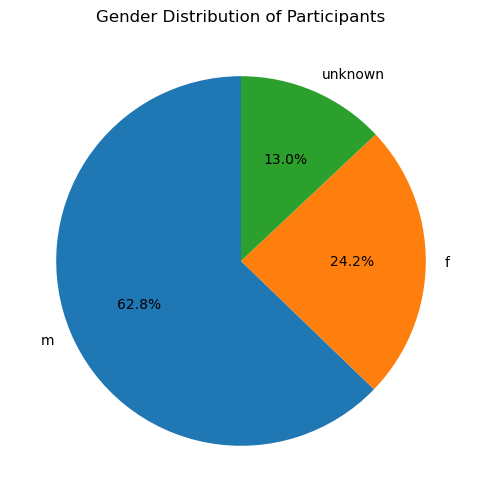

In [20]:
# Pie chart for gender distribution
plt.figure(figsize=(6, 6))
plt.pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title("Gender Distribution of Participants")
plt.show()

### Top 10 most common skills and interests

In [21]:
# Convert pipe-separated strings to lists for 'skills' and 'interests' columns
participants_expanded['skills'] = participants_expanded['skills'].fillna(",").apply(lambda x: x.split("|") if x else [])
participants_expanded['interests'] = participants_expanded['interests'].fillna(",").apply(lambda x: x.split("|") if x else [])
participants_expanded[['skills','interests']]

,skills,interests
0,"[,]","[,]"
1,"[wordpress, python, tableau, excel, Blockchain, ]","[AR/VR, Blockchain, Communication, Cybersecuri..."
2,"[java, c++, javascript, angular.js, css, html,...","[Beginner Friendly, Blockchain, Cybersecurity,..."
3,"[java, javascript, ]","[Communication, Cybersecurity, Gaming, IoT, Ma..."
4,"[android, javascript, php, java, ios, jquery, ...","[,]"
...,...,...
56490,"[python, java, react, react-native, firebase, ...","[AR/VR, Blockchain, E-commerce/Retail, Fintech..."
56491,"[mac, web, windows, ]","[,]"
56492,"[,]","[,]"
56493,"[web, react, python, flask, html5, websockets,...","[Beginner Friendly, Design, Education, Health,..."


In [22]:
from collections import Counter
import itertools

# Skills
all_skills = list(itertools.chain.from_iterable(participants_expanded['skills']))
skill_counts = Counter(all_skills)
common_skills = skill_counts.most_common(12) # top 10 most common skills 

# Interests
all_interests = list(itertools.chain.from_iterable(participants_expanded['interests']))
interest_counts = Counter(all_interests)
common_interests = interest_counts.most_common(12) # top 10 most common 

common_skills, common_interests
common_skills.remove(('', 45946)) # removing nonsensical values
common_skills.remove((',', 10549)) # removing nonsensical values
common_interests.remove((',', 30625)) # removing nonsensical values
common_interests.remove(('', 25870)) # removing nonsensical values

print('common skills',common_skills)
print('common interests',common_interests)

common skills [('python', 23910), ('java', 21142), ('javascript', 17249), ('c++', 9995), ('html5', 8812), ('css', 8472), ('c', 6976), ('html', 6041), ('Blockchain', 5969), ('android', 5058)]
common interests [('Machine Learning/AI', 13487), ('Social Good', 9438), ('Productivity', 9097), ('Gaming', 8148), ('Communication', 6418), ('IoT', 6063), ('Cybersecurity', 6005), ('AR/VR', 5974), ('Blockchain', 5969), ('Lifehacks', 5299)]


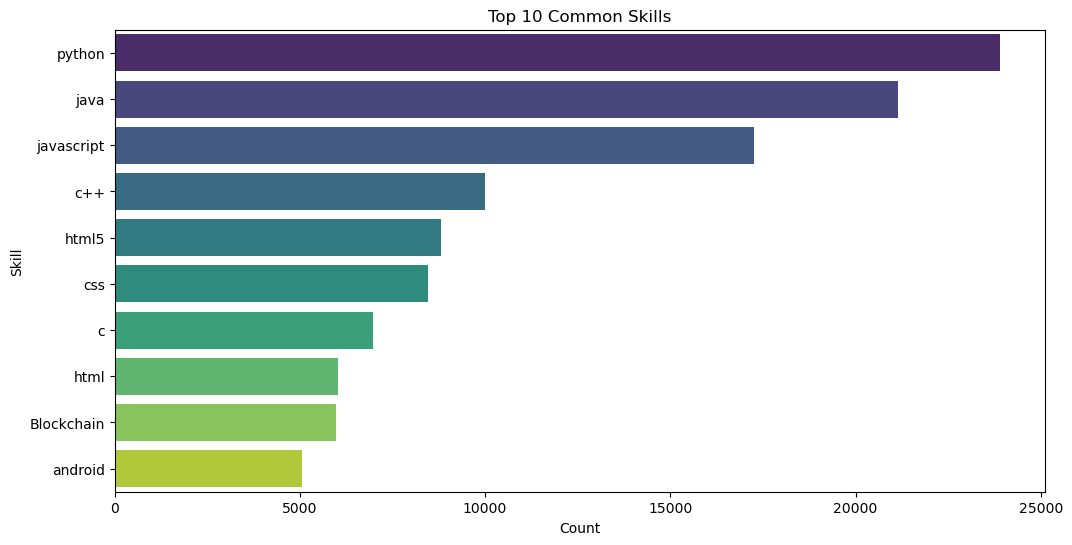

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot most common skills
skills_df = pd.DataFrame(common_skills, columns=['Skill', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Skill', data=skills_df, palette='viridis')
plt.title("Top 10 Common Skills")
plt.show()


### Skill distribution for males and females

In [24]:
male_participants = participants_expanded[participants_expanded['Gender'] == 'm']
female_participants = participants_expanded[participants_expanded['Gender'] == 'f']
# For Males
male_skills = list(itertools.chain.from_iterable(male_participants['skills']))
male_skill_counts = Counter(male_skills)
common_male_skills = [item for item in male_skill_counts.most_common(12) if item[0] not in ['', ',']]

male_interests = list(itertools.chain.from_iterable(male_participants['interests']))
male_interest_counts = Counter(male_interests)
common_male_interests = [item for item in male_interest_counts.most_common(12) if item[0] not in ['', ',']]

# For Females
female_skills = list(itertools.chain.from_iterable(female_participants['skills']))
female_skill_counts = Counter(female_skills)
common_female_skills = [item for item in female_skill_counts.most_common(12) if item[0] not in ['', ',']]

female_interests = list(itertools.chain.from_iterable(female_participants['interests']))
female_interest_counts = Counter(female_interests)
common_female_interests = [item for item in female_interest_counts.most_common(12) if item[0] not in ['', ',']]

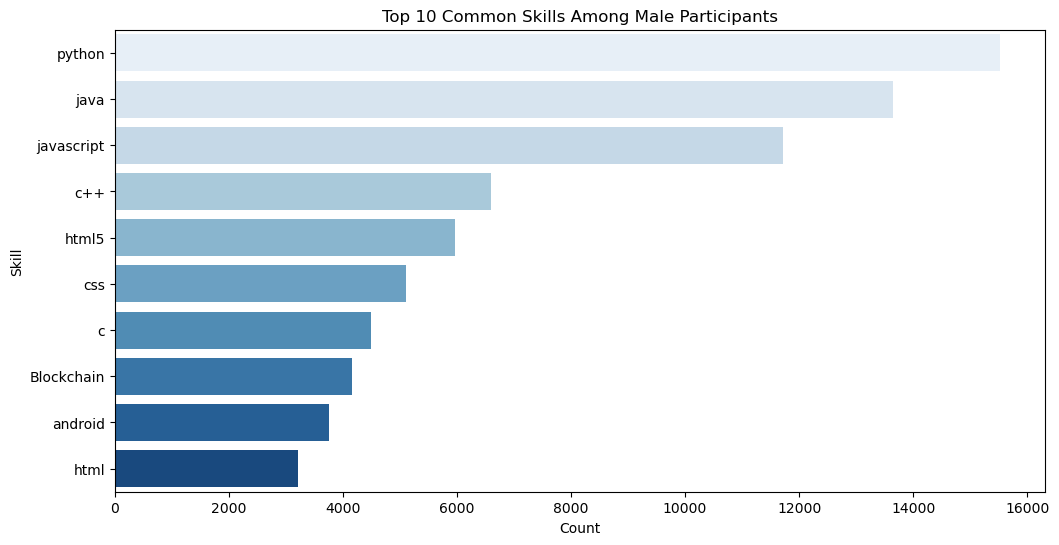

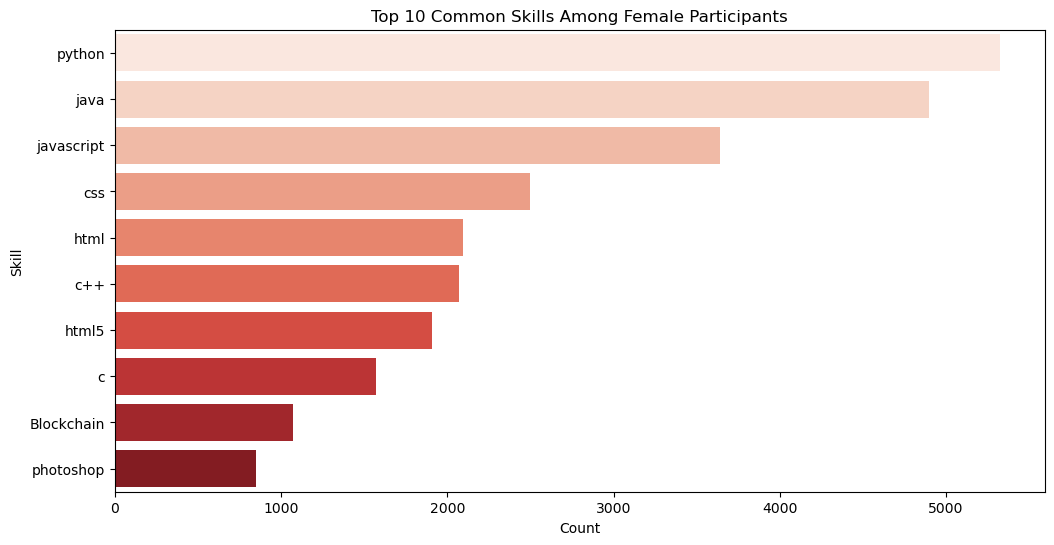

In [25]:
# Skills for Males
skills_male_df = pd.DataFrame(common_male_skills, columns=['Skill', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Skill', data=skills_male_df, palette='Blues')
plt.title("Top 10 Common Skills Among Male Participants")
plt.show()

# Skills for Females
skills_female_df = pd.DataFrame(common_female_skills, columns=['Skill', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Skill', data=skills_female_df, palette='Reds')
plt.title("Top 10 Common Skills Among Female Participants")
plt.show()

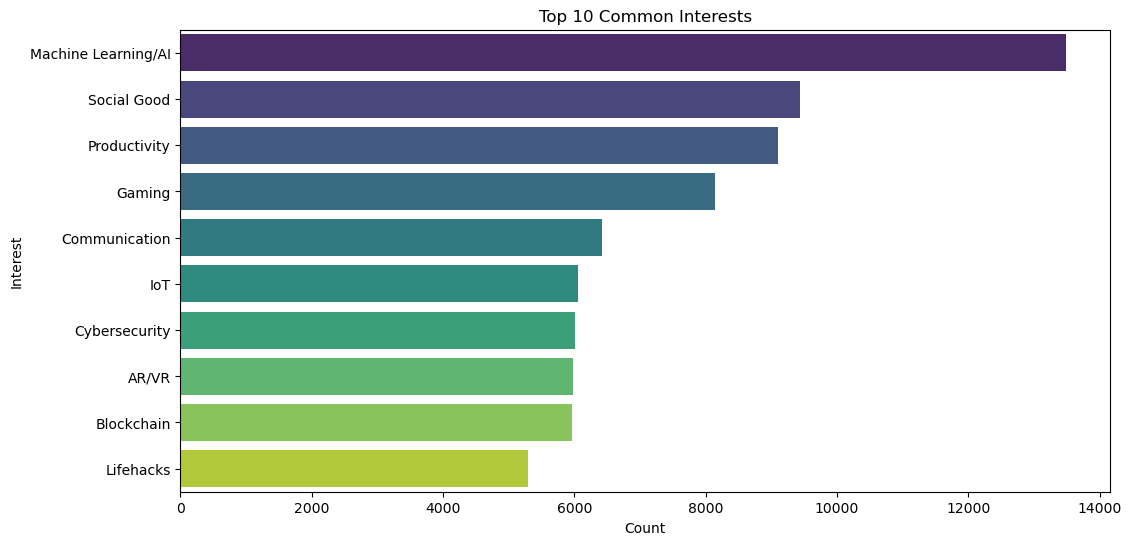

In [26]:
# Plot most common interests
interests_df = pd.DataFrame(common_interests, columns=['Interest', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Interest', data=interests_df, palette='viridis')
plt.title("Top 10 Common Interests")
plt.show()

### Interest distribution for males and females

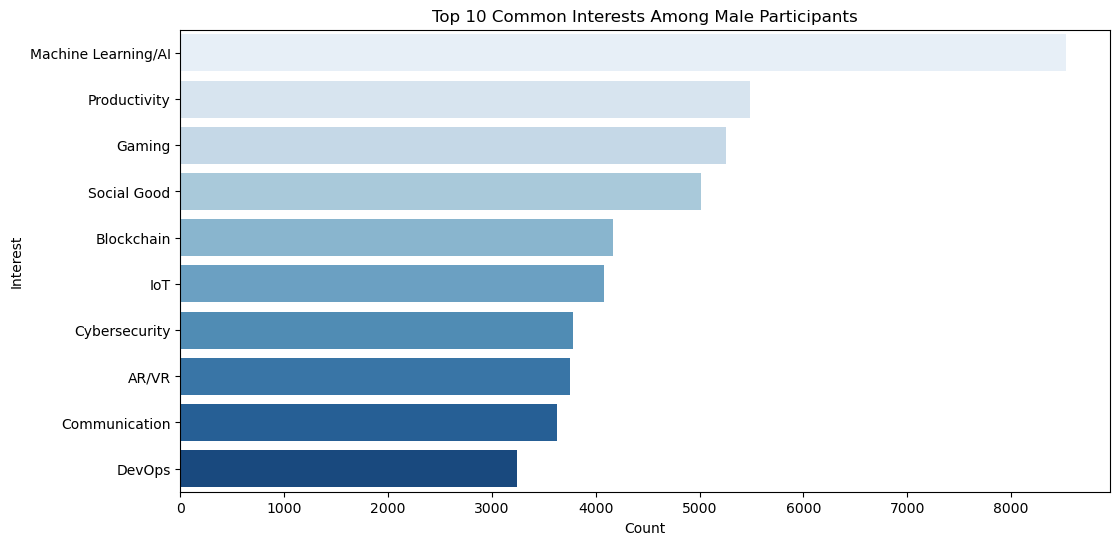

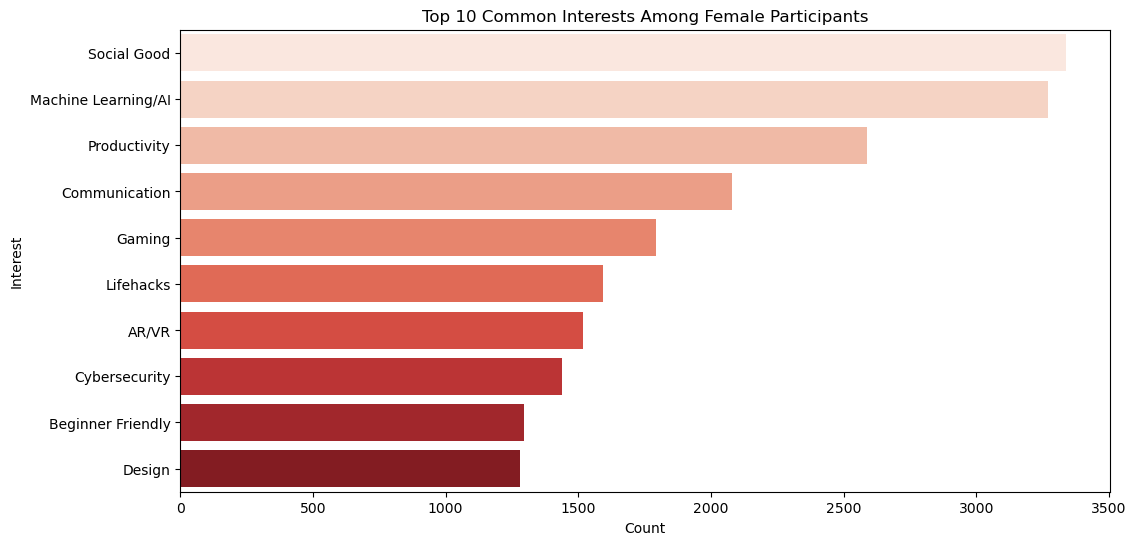

In [27]:
# Interests for Males
interests_male_df = pd.DataFrame(common_male_interests, columns=['Interest', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Interest', data=interests_male_df, palette='Blues')
plt.title("Top 10 Common Interests Among Male Participants")
plt.show()

# Interests for Females
interests_female_df = pd.DataFrame(common_female_interests, columns=['Interest', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Interest', data=interests_female_df, palette='Reds')
plt.title("Top 10 Common Interests Among Female Participants")
plt.show()

In [28]:
print('common male skills: ',common_male_skills)
print('common female skills: ',common_female_skills)
print('common male interests: ',common_male_interests)
print('common female interests: ',common_female_interests)

common male skills:  [('python', 15528), ('java', 13654), ('javascript', 11711), ('c++', 6592), ('html5', 5966), ('css', 5109), ('c', 4496), ('Blockchain', 4166), ('android', 3761), ('html', 3209)]
common female skills:  [('python', 5326), ('java', 4896), ('javascript', 3639), ('css', 2495), ('html', 2097), ('c++', 2068), ('html5', 1911), ('c', 1571), ('Blockchain', 1074), ('photoshop', 851)]
common male interests:  [('Machine Learning/AI', 8529), ('Productivity', 5488), ('Gaming', 5255), ('Social Good', 5010), ('Blockchain', 4166), ('IoT', 4080), ('Cybersecurity', 3782), ('AR/VR', 3751), ('Communication', 3627), ('DevOps', 3238)]
common female interests:  [('Social Good', 3338), ('Machine Learning/AI', 3272), ('Productivity', 2588), ('Communication', 2080), ('Gaming', 1793), ('Lifehacks', 1595), ('AR/VR', 1518), ('Cybersecurity', 1439), ('Beginner Friendly', 1295), ('Design', 1281)]


### Tecnical skills VS programming languages

In [29]:
# Define function to separate skills after seeing the summarised results
def separate_skills(skill_list):
    programming_languages = {'python', 'java', 'javascript', 'c++', 'html5', 'css', 'c', 'html'}
    technical_skills = {'Blockchain', 'android', 'photoshop'}

    lang_dict = {skill: count for skill, count in skill_list if skill in programming_languages}
    tech_dict = {skill: count for skill, count in skill_list if skill in technical_skills}
    return lang_dict, tech_dict

# Separate skills for males and females
male_langs, male_techs = separate_skills(common_male_skills)
female_langs, female_techs = separate_skills(common_female_skills)

In [30]:
## total counts of programming languages and technical skills by gender
# Summing counts
total_male_langs = sum(male_langs.values())
total_female_langs = sum(female_langs.values())
total_male_techs = sum(male_techs.values())
total_female_techs = sum(female_techs.values())

# Comparisons
print("Male vs Female - Programming Languages:")
print(f"Males: {total_male_langs}, Females: {total_female_langs}")

print("Male vs Female - Technical Skills:")
print(f"Males: {total_male_techs}, Females: {total_female_techs}")

Male vs Female - Programming Languages:
Males: 66265, Females: 24003
Male vs Female - Technical Skills:
Males: 7927, Females: 1925


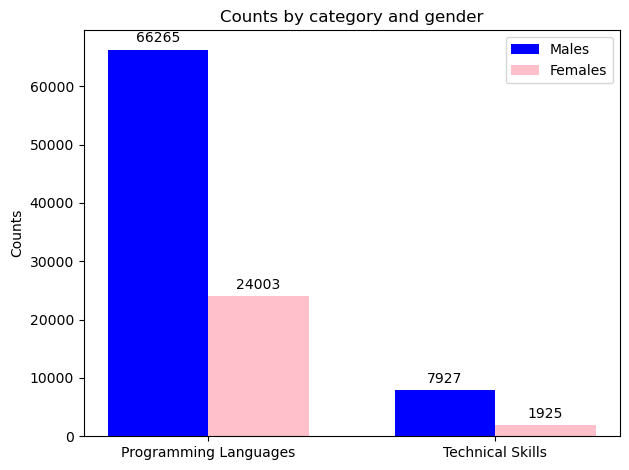

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
categories = ['Programming Languages', 'Technical Skills']
male_counts = [total_male_langs, total_male_techs]
female_counts = [total_female_langs, total_female_techs]

x = np.arange(len(categories))  # the label locations, converted to a numpy array
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male_counts, width, label='Males', color='blue')
rects2 = ax.bar(x + width/2, female_counts, width, label='Females', color='pink')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts by category and gender')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Adding labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.show()


### Implications:
1) **Engagement and Learning Opportunities**: The disparity suggests potential areas where hackathons could focus on encouraging more female participation and engagement, especially in programming languages.
2) **Diversity Initiatives**: Hackathons and related tech events might consider implementing more targeted diversity initiatives, perhaps through workshops or mentorship programs aimed at boosting skill development for underrepresented genders in certain technical areas.

### Number of projects and hackathons each participant has been involved in

In [32]:
# Count the number of projects
participants_expanded['num_projects'] = participants_expanded['projects'].fillna("").apply(
    lambda x: len(x.split(",")) if x else 0
)

# Count the number of hackathons
participants_expanded['num_hackathons'] = participants_expanded['hackathons'].fillna("").apply(
    lambda x: len(x.split(",")) if x else 0
)

# Display the results
participants_expanded[['name', 'num_projects', 'num_hackathons']]

,name,num_projects,num_hackathons
0,Craig Hiller,1,1
1,Andrew Sheleby,1,1
2,Evan Ho,1,1
3,Brian Lam,4,4
4,lin peng,1,1
...,...,...,...
56490,Mike Dimitrov,1,1
56491,Baiyun (Ben) Gao,1,1
56492,Everet Siew,1,1
56493,Amulya Garimella,1,1


Descriptive Statistics for Number of Number of Projects engaged in by Participants:
count    56495.000000
mean         1.365838
std          1.338204
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         66.000000
Name: num_projects, dtype: float64
Descriptive Statistics for Number of Number of Hackathons engaged in by Participants:
count    56495.000000
mean         1.363360
std          1.335729
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         66.000000
Name: num_hackathons, dtype: float64


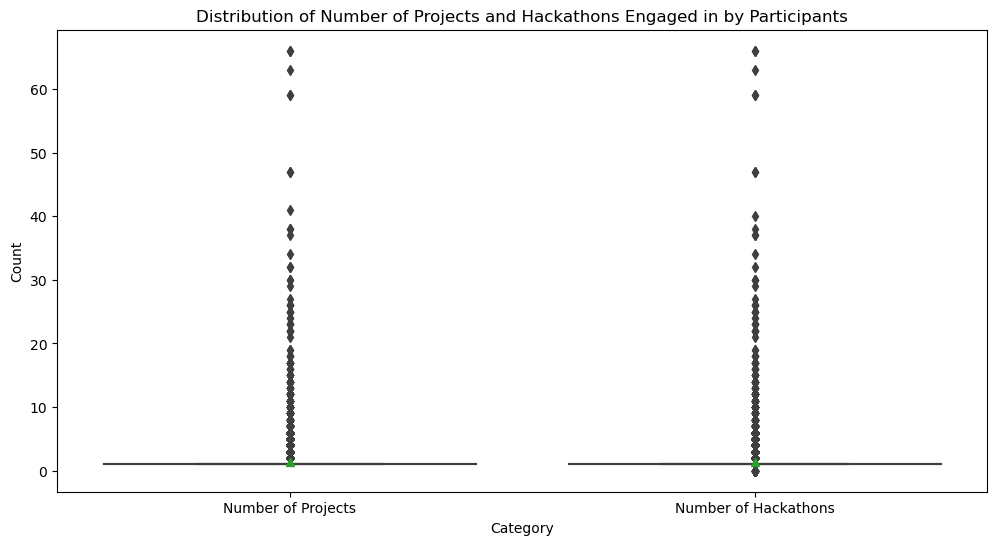

In [33]:
print("Descriptive Statistics for Number of Number of Projects engaged in by Participants:")
print(participants_expanded['num_projects'].describe())

print("Descriptive Statistics for Number of Number of Hackathons engaged in by Participants:")
print(participants_expanded['num_hackathons'].describe())

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=participants_expanded[['num_projects', 'num_hackathons']], showmeans=True)
plt.title("Distribution of Number of Projects and Hackathons Engaged in by Participants")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks([0, 1], ['Number of Projects', 'Number of Hackathons'])
plt.show()

### Is there a correlation between the number of skills and the number of projects/ hackathons they have been involved with?

In [34]:
# Count the number of skills for each participant
participants_expanded['num_skills'] = participants_expanded['skills'].apply(len)

# Calculate correlations
correlation_projects = participants_expanded[['num_skills', 'num_projects']].corr().iloc[0, 1]
correlation_hackathons = participants_expanded[['num_skills', 'num_hackathons']].corr().iloc[0, 1]

correlation_projects, correlation_hackathons
#print('correlation found with number of skills each participant has and the number of projects participated in =',correlation_projects)
print('correlation found with number of skills each participant has and the number of hackathons participated in =',correlation_hackathons)

correlation found with number of skills each participant has and the number of hackathons participated in = 0.13488461112686292


correlation is relatively low meaning Little or no correlation

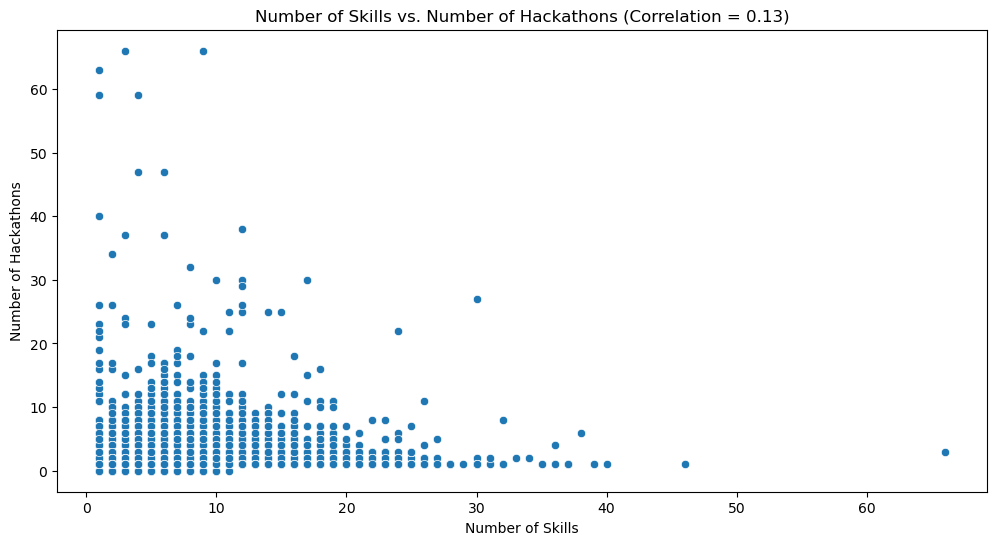

In [35]:
# Scatter plot for number of skills vs. number of hackathons
plt.figure(figsize=(12, 6))
sns.scatterplot(x='num_skills', y='num_hackathons', data=participants_expanded)
plt.title(f"Number of Skills vs. Number of Hackathons (Correlation = {correlation_hackathons:.2f})")
plt.xlabel("Number of Skills")
plt.ylabel("Number of Hackathons")
plt.show()

The correlation value in the plot is low, indicating that there isn't a strong linear relationship between the two variables. This could mean that other factors, such as interest or availability, play a more significant role in participation.

The majority of participants have fewer than 10 skills listed but they also participate in more hackathons with the assumed intention to learn and gain more experience.

Participants tend to focus on a limited number of skills and participate in fewer hackathons. This might indicate specialization, where participants focus on honing specific skills rather than being generalists.

Also the one person who has 66 skills has less than 10 hackathons 

### Gender distribution and hackathons

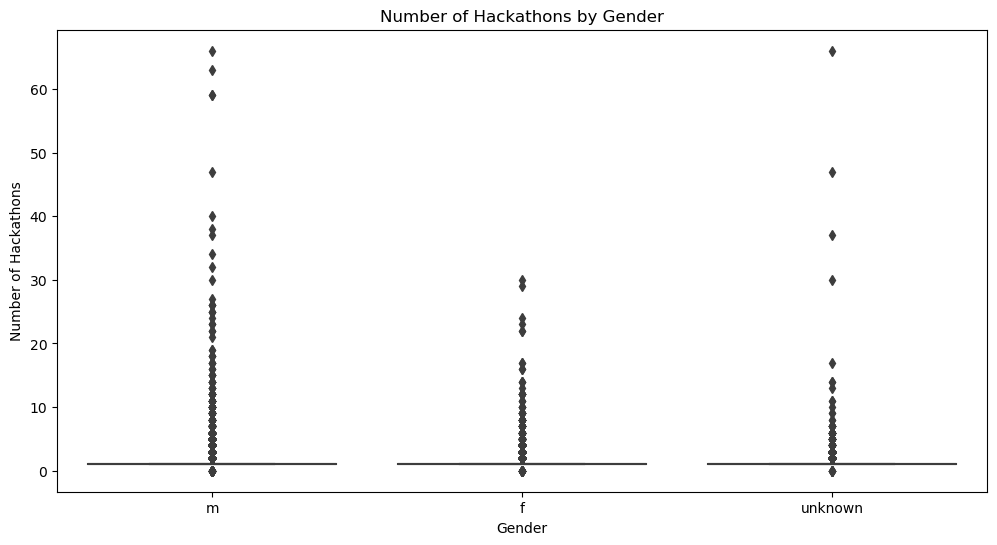

In [36]:
# Box plot for number of hackathons by gender
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gender', y='num_hackathons', data=participants_expanded)
plt.title("Number of Hackathons by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Hackathons")
plt.show()

### Distribution of females to males to unknown for each hackathon


In [ ]:
participants_expanded

In [37]:

# Step 1: Explode the hackathons column
participants_expanded_exploded = participants_expanded.explode('hackathons')

# Step 2: Group by hackathon URL and Gender and count unique participants
grouped_counts = participants_expanded_exploded.groupby(['hackathons', 'Gender']).size().reset_index(name='count')

# Step 3: Pivot the counts
pivoted_counts = grouped_counts.pivot(index='hackathons', columns='Gender', values='count').fillna(0)

# Rename columns
pivoted_counts = pivoted_counts.rename(columns={'f': 'females_participating', 
                                                'm': 'males_participating',
                                                'unknown': 'unknown_gender_participating'})

# Step 4: Merge with the hackathons DataFrame
merged_df = hackathons.merge(pivoted_counts, left_on='URL',right_index=True, how='left')

# Step 5: Validation (optional)
merged_df['total_participating'] = merged_df['females_participating'] + \
                                   merged_df['males_participating'] + \
                                   merged_df['unknown_gender_participating']

merged_df['is_valid'] = merged_df['total_participating'] == merged_df['registered_N']

# Drop the validation columns for the final result
merged_df = merged_df.drop(columns=['total_participating', 'is_valid'])

# Final result
print(merged_df)


                                               URL  \
0         https://wirvsvirushackathon.devpost.com/   
1               https://theglobalhack.devpost.com/   
2                   https://supernova.devpost.com/   
3               https://hajjhackathon.devpost.com/   
4         https://chainlinkspring2022.devpost.com/   
...                                            ...   
7048           https://checkinproject.devpost.com/   
7049                  https://fgtfrgf.devpost.com/   
7050                https://old-hacks.devpost.com/   
7051  https://thailand-champion-13627.devpost.com/   
7052        https://manager-hackathon.devpost.com/   

                                       Judging Criteria     schedule  \
0     Gesellschaftlicher Mehrwert, Innovationsgrad, ...  no schedule   
1     Potential impact of the project, Technical exe...  no schedule   
2     X Factor and Potential, Technical Competence, ...  no schedule   
3     Design           |             التصميم, Simpli...  no sch

In [38]:
merged_df[['females_participating', 'males_participating',
       'unknown_gender_participating','registered_N','URL']]

,females_participating,males_participating,unknown_gender_participating,registered_N,URL
0,175.0,365.0,59.0,12505,https://wirvsvirushackathon.devpost.com/
1,85.0,168.0,38.0,6059,https://theglobalhack.devpost.com/
2,7.0,26.0,11.0,3633,https://supernova.devpost.com/
3,102.0,248.0,31.0,2935,https://hajjhackathon.devpost.com/
4,11.0,54.0,6.0,1481,https://chainlinkspring2022.devpost.com/
...,...,...,...,...,...
7048,NaN,NaN,NaN,1,https://checkinproject.devpost.com/
7049,NaN,NaN,NaN,1,https://fgtfrgf.devpost.com/
7050,NaN,NaN,NaN,1,https://old-hacks.devpost.com/
7051,NaN,NaN,NaN,0,https://thailand-champion-13627.devpost.com/


From this it is clear that the registered_N may not be equal to the number of people who actually ended up participating and submitting something. Thus, creating another column that is called actual_participants_N which is a sum of the values of females_participating + males_participating + unknown_gender_participating:

In [39]:
# Creating the actual_participants_N column
merged_df['actual_participants_N'] = (
    merged_df['females_participating'].fillna(0) +
    merged_df['males_participating'].fillna(0) +
    merged_df['unknown_gender_participating'].fillna(0)
)

# Displaying the result
merged_df[['females_participating', 'males_participating',
                 'unknown_gender_participating', 'registered_N',
                 'actual_participants_N', 'URL']]

,females_participating,males_participating,unknown_gender_participating,registered_N,actual_participants_N,URL
0,175.0,365.0,59.0,12505,599.0,https://wirvsvirushackathon.devpost.com/
1,85.0,168.0,38.0,6059,291.0,https://theglobalhack.devpost.com/
2,7.0,26.0,11.0,3633,44.0,https://supernova.devpost.com/
3,102.0,248.0,31.0,2935,381.0,https://hajjhackathon.devpost.com/
4,11.0,54.0,6.0,1481,71.0,https://chainlinkspring2022.devpost.com/
...,...,...,...,...,...,...
7048,NaN,NaN,NaN,1,0.0,https://checkinproject.devpost.com/
7049,NaN,NaN,NaN,1,0.0,https://fgtfrgf.devpost.com/
7050,NaN,NaN,NaN,1,0.0,https://old-hacks.devpost.com/
7051,NaN,NaN,NaN,0,0.0,https://thailand-champion-13627.devpost.com/


In [40]:
# Assuming merged_df already exists and has the 'actual_participants_N' column
count_zero_or_nan = ((merged_df['actual_participants_N'] == 0) | (merged_df['actual_participants_N'].isna())).sum()

print(count_zero_or_nan)

# Remove rows where actual_participants_N is 0 or NaN
merged_df = merged_df[(merged_df['actual_participants_N'] != 0) & (~merged_df['actual_participants_N'].isna())]

2173


In [41]:
merged_df

,URL,Judging Criteria,schedule,hack_type,info,start_date_format,end_date_format,Prizes,prize_money,Id,...,Judges,Eligibility,Requirements,participation_type,prize_money_status,duration_days,females_participating,males_participating,unknown_gender_participating,actual_participants_N
0,https://wirvsvirushackathon.devpost.com/,"Gesellschaftlicher Mehrwert, Innovationsgrad, ...",no schedule,Public,"Mar 29, 2020, Online, Public, Social Good ...",2020-03-20,2020-03-22,"Euer Preis ist Anerkennung und Ehre!, Habt Spa...",no money prize,9683,...,['Jury'],Eligibility Diese Hackathon Seite richtet sich...,Diese Hackathon Seite richtet sich an die Teil...,Online,No Prize Money,2,175.0,365.0,59.0,599.0
1,https://theglobalhack.devpost.com/,"Potential impact of the project, Technical exe...",no schedule,Public,"Apr 12, 2020, Online, Public, COVID-19",2020-04-03,2020-04-09,Overall Winner,no money prize,9854,...,['TBA'],Eligibility Participants: Individuals (over 18...,Participants: Individuals (over 18 years in ag...,Online,No Prize Money,6,85.0,168.0,38.0,291.0
2,https://supernova.devpost.com/,"X Factor and Potential, Technical Competence, ...",no schedule,Public,"Jul 11, 2022, Online, Public, DFINITY Foundati...",2022-05-10,2022-06-22,"SocialFi - 1ST PLACE, SocialFi - 2ND PLACE, So...","$765,000",13738,...,"['Olaf Carlson-Wee', 'Maria Shen', 'Tom Serres...",Requirements HACKATHON TRACKS The hackathon ha...,HACKATHON TRACKS The hackathon has six super i...,Online,Has Prize Money,43,7.0,26.0,11.0,44.0
3,https://hajjhackathon.devpost.com/,"Design | التصميم, Simpli...",no schedule,Public,"Aug 3, 2018, Jeddah International Exhibition &...",2018-08-01,2018-08-03,1st place: 1 million Saudi Riyal (15% equity i...,"SAR2,000,000",6815,...,['TBD'],Requirements Devpost Deadline 1 - First projec...,Devpost Deadline 1 - First project submission ...,Offline,Has Prize Money,2,102.0,248.0,31.0,381.0
4,https://chainlinkspring2022.devpost.com/,"User Experience / User Interface, Originality ...",no schedule,Public,"Jun 8, 2022, Online, Public, Chainlink Labs, B...",2022-04-22,2022-05-28,"Chainlink Grand Prize - $40,000, Chainlink NFT...","$1,019,000",15086,...,"['Austin Griffith', 'Allen Day', 'Ivan Liljeqv...",Requirements Each project must use Chainlink i...,Each project must use Chainlink in some form t...,Online,Has Prize Money,36,11.0,54.0,6.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,https://genhacks-iv.devpost.com/,First Place,no schedule,Public,"Mar 19 – 21, 2021, Online, Public, Mission Vis...",2021-03-20,2021-03-21,First Place,"$7,000",12314,...,['TBA from Faculty and Industry!'],Eligibility If you are a student at Irvine Val...,If you are a student at Irvine Valley College ...,Online,Has Prize Money,1,0.0,1.0,0.0,1.0
7021,https://bockbockhack.devpost.com/,"Big Brain, Technical challenge, Polish/Integra...",no schedule,Invite only,"Jun 13 – 14, 2022, University of Cambridge - J...",2022-06-13,2022-06-14,"1st Prize, 2nd Prize, 3rd Prize, Biggest Brain...",£222,15634,...,"['Andy Phung', 'Suryabhan Mohapatra', 'Viha Sh...",Requirements We highly recommend hosting your ...,We highly recommend hosting your source code o...,Offline,Has Prize Money,1,0.0,1.0,0.0,1.0
7024,https://valleyhacks2021.devpost.com/,"Functionality, Originality, Scope, Design",no schedule,Public,"Apr 9 – 11, 2021, Online, Public, Irvine Valle...",2021-04-10,2021-04-11,"1st Place, 2nd Place, 3rd Place",$175,11831,...,"['Afton Ojuri', 'Trevor Masse', 'Blair Kahn']",Requirements Submit your pitch deck in PDF for...,Submit your pitch deck in PDF form (please con...,Online,Has Prize Money,1,0.0,1.0,0.0,1.0
7035,https://provihack.devpost.com/,"Qualidade, teste",no schedule,Invite only,"Nov 19, 2021 – Apr 14, 2022, Online, Invite on...",2021-11-19,2022-04-14,TBD (3),no money prize,13442,...,"['Sairikun', 'fuyutarow@gmail.com', 'ani']",Eligibility information not provided,Grand Prize hehe,Online,No Prize Money,146,0.0,1.0,0.0,1.0


### Male vs female participation for ONLINE events:

In [42]:
# Filter for online hackathons
online_hackathons = merged_df[merged_df['participation_type'] == 'Online']

# Summarize male vs female participation
gender_distribution_online = online_hackathons[['males_participating', 'females_participating']].sum()
print(gender_distribution_online)

males_participating      10263.0
females_participating     4885.0
dtype: float64


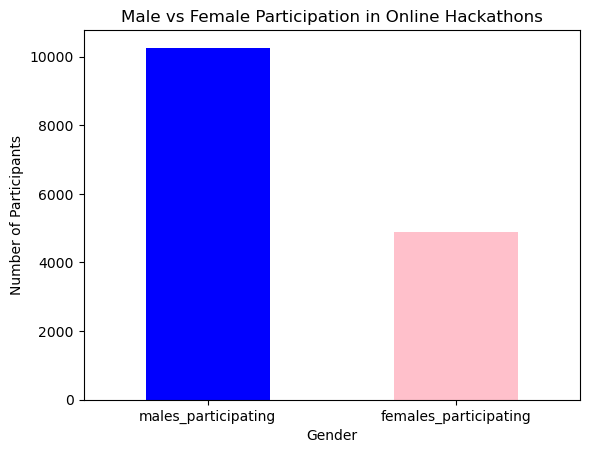

In [43]:
# Plotting
gender_distribution_online.plot(kind='bar', color=['blue', 'pink'])
plt.title('Male vs Female Participation in Online Hackathons')
plt.xlabel('Gender')
plt.ylabel('Number of Participants')
plt.xticks(rotation=0)  # Keeps the gender labels horizontal
plt.show()

### Male vs female participation for OFFLINE events:

In [44]:
offline_hackathons = merged_df[merged_df['participation_type'] == 'Offline']

gender_distribution_offline = offline_hackathons[['males_participating', 'females_participating']].sum()
print(gender_distribution_offline)


males_participating      17790.0
females_participating     6310.0
dtype: float64


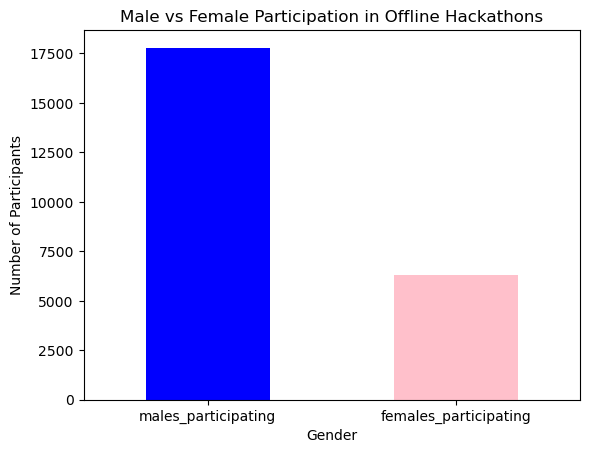

In [45]:
# Plotting
gender_distribution_offline.plot(kind='bar', color=['blue', 'pink'])
plt.title('Male vs Female Participation in Offline Hackathons')
plt.xlabel('Gender')
plt.ylabel('Number of Participants')
plt.xticks(rotation=0)  # Keeps the gender labels horizontal
plt.show()

### Adding the time trend to male and female participation in online vs offline events

In [46]:
# Assuming start_date_format is in datetime format
merged_df['start_date_format'] = pd.to_datetime(merged_df['start_date_format'])
merged_df.set_index('start_date_format', inplace=True)

# Online trend
online_trend = merged_df[merged_df['participation_type'] == 'Online']
online_trend = online_trend.resample('M')[['males_participating', 'females_participating']].sum()

# Offline trend
offline_trend = merged_df[merged_df['participation_type'] == 'Offline']
offline_trend = offline_trend.resample('M')[['males_participating', 'females_participating']].sum()

/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_21685/1785492806.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  online_trend = online_trend.resample('M')[['males_participating', 'females_participating']].sum()
/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_21685/1785492806.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offline_trend = offline_trend.resample('M')[['males_participating', 'females_participating']].sum()


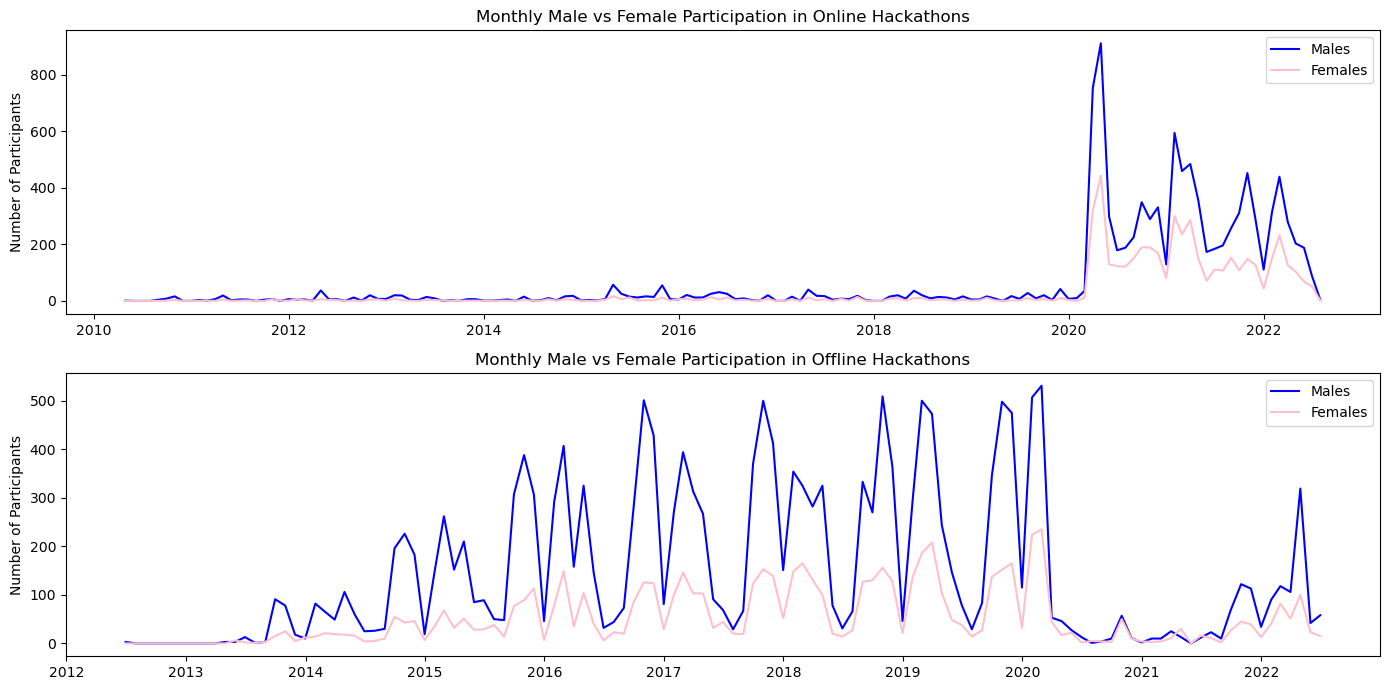

In [47]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(online_trend.index, online_trend['males_participating'], label='Males', color='blue')
plt.plot(online_trend.index, online_trend['females_participating'], label='Females', color='pink')
plt.title('Monthly Male vs Female Participation in Online Hackathons')
plt.ylabel('Number of Participants')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(offline_trend.index, offline_trend['males_participating'], label='Males', color='blue')
plt.plot(offline_trend.index, offline_trend['females_participating'], label='Females', color='pink')
plt.title('Monthly Male vs Female Participation in Offline Hackathons')
plt.ylabel('Number of Participants')
plt.legend()

plt.tight_layout()
plt.show()

### Graph interpretation:

**Online hackathons (top graph):** 
- Low Participation Initially: Both male and female participation in online hackathons starts off quite low, with almost parallel and minimal activity up until around 2016. This could suggest limited availability or lower popularity of online hackathons during the early years.
- Peak and Volatility: The peak in participation occurs around 2020, which likely corresponds with the onset of the COVID-19 pandemic—a period during which many events moved to an online format. The graph shows high volatility around this peak, suggesting perhaps rapid changes in the number or scale of events being organized.
- Decline Towards 2022: Both lines show a decline post-peak, which could indicate a stabilization as the world began adapting to new norms or a potential return to in-person events.

**Offline hackathons (bottom graph):**
- Higher Volatility: The graph for offline hackathons exhibits greater volatility and more pronounced peaks compared to online hackathons. This might be due to seasonal effects where certain months may consistently have more hackathons, possibly aligned with academic calendars or industry conference cycles.
- Gender Gap: Similar to the online hackathons, male participation is notably higher than female participation across the timeline. The gap appears to be somewhat consistent but with moments where it narrows slightly.
- Trend in Female Participation: While male participation shows large jumps, female participation, though lower and following the same trend, appears slightly steadier without as extreme spikes.

Overall Interpretation
Persistent Gender Gap: In both online and offline formats, male participation outweighs female participation. This underscores a gender disparity that hackathon organizers might need to address.
Impact of External Events: The pandemic visibly impacted online participation, highlighting how external factors can significantly affect the mode and scale of hackathon participation.
Volatility in Offline Events: The higher variability in offline event participation could reflect the logistical challenges and higher commitments required for in-person participation.